In [ ]:
!pip install python-docx

!pip install PyPDF2

!pip install --upgrade pip
#!pip install tensorflow==2.15.0 -q
!pip install --upgrade transformers==4.52.1 accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 6.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 87.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 51.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 85.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 114.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 106.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.

# PREPROCESSING OF THE TWO DATASETS:
- use all-MiniLM-L6-v2 to generate semantic embeddings (not used in my later cells)
-  full text extraction from PDF using PyPDF2

In [ ]:
# Fix the IPython widgets issue first
!pip install --upgrade ipywidgets
!pip install --upgrade notebook

import pandas as pd
import numpy as np
# Import regular tqdm instead of notebook version to avoid widget issues
from tqdm import tqdm
import pickle
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    !pip install sentence-transformers
    from sentence_transformers import SentenceTransformer

# Function to generate embeddings
def generate_embeddings(texts, ids, model_name='all-MiniLM-L6-v2'):
    print(f"Generating embeddings using {model_name}...")
    model = SentenceTransformer(model_name)
    embeddings = []

    # Use regular tqdm instead of tqdm.notebook to avoid widget issues
    for i, text in enumerate(tqdm(texts, desc="Generating embeddings")):
        # Ensure text is a string and not empty
        if not isinstance(text, str):
            print(f"Warning: Item {i} is not a string. Converting to string.")
            text = str(text) if text is not None else ""

        # Clean and prepare text for better embedding quality
        if text and len(text.strip()) > 0:
            try:
                embedding = model.encode(text)
                embeddings.append(embedding)
            except Exception as e:
                print(f"Error encoding text at index {i}: {e}")
                # Use zero vector if encoding fails
                embeddings.append(np.zeros(model.get_sentence_embedding_dimension()))
        else:
            # Use zero vector for empty text
            print(f"Warning: Empty text at index {i}. Using zero vector.")
            embeddings.append(np.zeros(model.get_sentence_embedding_dimension()))

    # Create a dictionary mapping ID to embedding
    embedding_dict = {ids[i]: embeddings[i] for i in range(len(ids))}

    return embeddings, embedding_dict

# Main function to process the translated dataset
def process_english_text_dataset(csv_path):
    print(f"Loading data from {csv_path}...")
    # Read the CSV file
    df = pd.read_csv(csv_path)

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Ensure the required columns exist
    if 'id' not in df.columns or 'full_text_english' not in df.columns:
        missing_cols = []
        if 'id' not in df.columns: missing_cols.append('id')
        if 'full_text_english' not in df.columns: missing_cols.append('full_text_english')
        raise ValueError(f"Missing required columns: {', '.join(missing_cols)}")

    # Clean the data
    # Fill any missing values in full_text_english with empty strings
    df['full_text_english'] = df['full_text_english'].fillna("")

    # Convert any non-string values to strings
    for i, val in enumerate(df['full_text_english']):
        if not isinstance(val, str):
            df.loc[i, 'full_text_english'] = str(val) if val is not None else ""

    # Prepare data for embedding
    texts = df["full_text_english"].tolist()
    ids = df["id"].tolist()

    # Generate embeddings
    embeddings, embedding_dict = generate_embeddings(texts, ids)

    # Save embeddings to files
    with open("cv_english_embeddings.pkl", "wb") as f:
        pickle.dump(embeddings, f)

    # Save embeddings with IDs to file
    with open("cv_english_embeddings_with_ids.pkl", "wb") as f:
        pickle.dump(embedding_dict, f)

    print(f"Generated and saved embeddings for {len(embeddings)} documents")
    print(f"Saved ID-to-embedding mapping for later training use")

    # Display embedding information
    if embeddings and len(embeddings) > 0:
        print(f"\nEmbedding shape: {embeddings[0].shape}")
        print(f"Embedding sample (first 5 values): {embeddings[0][:5]}")
        print(f"Number of IDs in embedding dictionary: {len(embedding_dict)}")
        if embedding_dict:
            sample_id = list(embedding_dict.keys())[0]
            print(f"Sample ID in embedding dictionary: {sample_id}")

    return df, embeddings, embedding_dict

# Make sure we have the necessary packages
!pip install sentence-transformers

# Path to the CSV file
csv_path = "/kaggle/input/processed-prof-dataset-translated/processed_prof_dataset_ (5)_translated (3).csv"

# Process the dataset
df, embeddings, embedding_dict = process_english_text_dataset(csv_path)

# Show overall statistics
print("\nOverall Dataset Statistics:")
print(f"Total documents processed: {len(df)}")
print(f"Average text length: {df['full_text_english'].str.len().mean():.0f} characters")
print(f"Minimum text length: {df['full_text_english'].str.len().min()} characters")
print(f"Maximum text length: {df['full_text_english'].str.len().max()} characters")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 4.0.13
    Uninstalling widgetsnbextension-4.0.13:
      Successfully uninstalled widgetsnbextension-4.0.13
  Attempting uninstall: jupyterlab_widgets
    Found existing installation: jupyterlab_widgets 3.0.13━━━━━━━━ 1/3 [jupyterlab_widgets]
    Uninstalling jupyterlab_widgets-3.0.13:━━━━━━━━━━━━━━━━━━━ 1/3 [jupyterlab_widgets]
      Successfully uninstalled jupyterlab_widgets-3.0.13━━━━━━ 1/3 [jupyterlab_widgets]
  Attempting uninstall: ipywidgets0m━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [jupyterlab_widgets]
    Found existing installation: ipywidgets 8.1.5━━━━━━━━━━━━━ 1/3 [jupyterlab_widgets]
    Uninstalling ipywidgets-8.1.5:0m━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [jupyterlab_widgets]
      Successfully uninstalled ipywidgets-8.1.5━━━━━━━━━━━━━━━ 1/3 [jupyterlab_widgets]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [ipywidge

2025-06-28 12:15:20.953617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751112921.182248      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751112921.248691      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading data from /kaggle/input/processed-prof-dataset-translated/processed_prof_dataset_ (5)_translated (3).csv...
Dataset shape: (949, 11)
Columns: ['id', 'language', 'full_text', 'job_category', 'job_cluster', 'Age', 'Gender', 'Sexual_orientation', 'Ethnicity', 'Religion', 'full_text_english']
Generating embeddings using all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings:   0%|          | 0/949 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 1/949 [00:00<08:15,  1.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   1%|          | 5/949 [00:00<01:35,  9.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   1%|          | 10/949 [00:00<00:50, 18.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   2%|▏         | 15/949 [00:00<00:37, 25.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   2%|▏         | 19/949 [00:00<00:32, 28.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 24/949 [00:01<00:28, 32.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 29/949 [00:01<00:25, 36.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   4%|▎         | 34/949 [00:01<00:22, 39.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   4%|▍         | 39/949 [00:01<00:22, 41.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   5%|▍         | 45/949 [00:01<00:19, 45.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   5%|▌         | 51/949 [00:01<00:18, 48.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   6%|▌         | 57/949 [00:01<00:18, 48.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   7%|▋         | 63/949 [00:01<00:18, 47.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   7%|▋         | 69/949 [00:02<00:18, 47.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 74/949 [00:02<00:18, 47.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 80/949 [00:02<00:17, 50.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   9%|▉         | 86/949 [00:02<00:17, 50.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  10%|▉         | 92/949 [00:02<00:17, 49.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  10%|█         | 98/949 [00:02<00:17, 48.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  11%|█         | 103/949 [00:02<00:17, 48.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  11%|█▏        | 109/949 [00:02<00:16, 50.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  12%|█▏        | 115/949 [00:02<00:16, 49.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  13%|█▎        | 121/949 [00:03<00:16, 49.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  13%|█▎        | 127/949 [00:03<00:15, 51.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  14%|█▍        | 133/949 [00:03<00:16, 50.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  15%|█▍        | 139/949 [00:03<00:15, 53.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  15%|█▌        | 145/949 [00:03<00:15, 52.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  16%|█▌        | 151/949 [00:03<00:15, 50.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  17%|█▋        | 157/949 [00:03<00:15, 50.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  17%|█▋        | 164/949 [00:03<00:14, 55.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  18%|█▊        | 171/949 [00:03<00:13, 56.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  19%|█▊        | 177/949 [00:04<00:13, 57.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  19%|█▉        | 183/949 [00:04<00:13, 55.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  20%|█▉        | 189/949 [00:04<00:14, 53.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  21%|██        | 195/949 [00:04<00:14, 51.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  21%|██        | 201/949 [00:04<00:14, 50.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  22%|██▏       | 207/949 [00:04<00:14, 50.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  23%|██▎       | 214/949 [00:04<00:13, 52.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  23%|██▎       | 220/949 [00:04<00:14, 51.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  24%|██▍       | 226/949 [00:05<00:15, 48.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  24%|██▍       | 231/949 [00:05<00:14, 48.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  25%|██▍       | 236/949 [00:05<00:14, 48.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  25%|██▌       | 241/949 [00:05<00:14, 48.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  26%|██▌       | 247/949 [00:05<00:14, 48.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  27%|██▋       | 252/949 [00:05<00:14, 48.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  27%|██▋       | 258/949 [00:05<00:13, 51.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  28%|██▊       | 264/949 [00:05<00:12, 54.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  29%|██▊       | 271/949 [00:05<00:11, 57.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  29%|██▉       | 277/949 [00:06<00:12, 54.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  30%|██▉       | 283/949 [00:06<00:12, 52.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  30%|███       | 289/949 [00:06<00:12, 51.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  31%|███       | 295/949 [00:06<00:12, 51.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  32%|███▏      | 301/949 [00:06<00:13, 49.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  32%|███▏      | 307/949 [00:06<00:13, 48.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  33%|███▎      | 312/949 [00:06<00:13, 48.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  34%|███▎      | 318/949 [00:06<00:12, 50.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  34%|███▍      | 324/949 [00:06<00:12, 50.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  35%|███▍      | 330/949 [00:07<00:12, 48.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  36%|███▌      | 337/949 [00:07<00:11, 53.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  36%|███▌      | 343/949 [00:07<00:11, 52.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  37%|███▋      | 349/949 [00:07<00:11, 51.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  38%|███▊      | 356/949 [00:07<00:11, 53.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  38%|███▊      | 363/949 [00:07<00:10, 54.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  39%|███▉      | 370/949 [00:07<00:09, 58.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  40%|███▉      | 376/949 [00:07<00:10, 52.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  40%|████      | 382/949 [00:08<00:11, 51.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  41%|████      | 389/949 [00:08<00:10, 55.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  42%|████▏     | 396/949 [00:08<00:09, 57.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  42%|████▏     | 402/949 [00:08<00:10, 54.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  43%|████▎     | 408/949 [00:08<00:10, 53.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  44%|████▎     | 414/949 [00:08<00:10, 52.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  44%|████▍     | 420/949 [00:08<00:10, 50.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  45%|████▍     | 426/949 [00:08<00:10, 48.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  45%|████▌     | 431/949 [00:09<00:10, 48.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  46%|████▌     | 437/949 [00:09<00:10, 49.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  47%|████▋     | 443/949 [00:09<00:10, 49.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  47%|████▋     | 449/949 [00:09<00:11, 44.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  48%|████▊     | 454/949 [00:09<00:11, 44.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  48%|████▊     | 460/949 [00:09<00:10, 48.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  49%|████▉     | 465/949 [00:09<00:10, 48.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  50%|████▉     | 470/949 [00:09<00:10, 47.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  50%|█████     | 475/949 [00:09<00:09, 47.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  51%|█████     | 481/949 [00:10<00:09, 49.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  51%|█████     | 486/949 [00:10<00:09, 49.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  52%|█████▏    | 493/949 [00:10<00:08, 55.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  53%|█████▎    | 499/949 [00:10<00:08, 52.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  53%|█████▎    | 505/949 [00:10<00:08, 52.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  54%|█████▍    | 512/949 [00:10<00:07, 54.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  55%|█████▍    | 518/949 [00:10<00:07, 54.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  55%|█████▌    | 524/949 [00:10<00:08, 52.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  56%|█████▌    | 530/949 [00:10<00:08, 51.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  56%|█████▋    | 536/949 [00:11<00:08, 50.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  57%|█████▋    | 542/949 [00:11<00:08, 49.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  58%|█████▊    | 548/949 [00:11<00:07, 52.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  58%|█████▊    | 554/949 [00:11<00:07, 51.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  59%|█████▉    | 560/949 [00:11<00:07, 53.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  60%|█████▉    | 566/949 [00:11<00:06, 55.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  60%|██████    | 572/949 [00:11<00:06, 53.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  61%|██████    | 578/949 [00:11<00:06, 55.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  62%|██████▏   | 584/949 [00:12<00:06, 52.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  62%|██████▏   | 590/949 [00:12<00:06, 51.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  63%|██████▎   | 596/949 [00:12<00:06, 51.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  63%|██████▎   | 602/949 [00:12<00:06, 53.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  64%|██████▍   | 608/949 [00:12<00:06, 51.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  65%|██████▍   | 614/949 [00:12<00:06, 50.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  65%|██████▌   | 620/949 [00:12<00:06, 48.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  66%|██████▌   | 628/949 [00:12<00:05, 53.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  67%|██████▋   | 634/949 [00:12<00:05, 54.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  68%|██████▊   | 641/949 [00:13<00:05, 56.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  68%|██████▊   | 647/949 [00:13<00:05, 54.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  69%|██████▉   | 653/949 [00:13<00:05, 53.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  69%|██████▉   | 659/949 [00:13<00:05, 51.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  70%|███████   | 665/949 [00:13<00:05, 50.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  71%|███████   | 671/949 [00:13<00:05, 50.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  71%|███████▏  | 677/949 [00:13<00:05, 50.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  72%|███████▏  | 684/949 [00:13<00:05, 52.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  73%|███████▎  | 690/949 [00:14<00:05, 43.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  73%|███████▎  | 697/949 [00:14<00:05, 47.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▍  | 702/949 [00:14<00:05, 47.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▍  | 707/949 [00:14<00:05, 47.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  75%|███████▌  | 712/949 [00:14<00:05, 47.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  76%|███████▌  | 717/949 [00:14<00:04, 47.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  76%|███████▌  | 722/949 [00:14<00:04, 45.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  77%|███████▋  | 727/949 [00:14<00:04, 46.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  77%|███████▋  | 732/949 [00:14<00:04, 46.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  78%|███████▊  | 739/949 [00:15<00:04, 49.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  78%|███████▊  | 744/949 [00:15<00:04, 49.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  79%|███████▉  | 749/949 [00:15<00:04, 48.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  79%|███████▉  | 754/949 [00:15<00:04, 48.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  80%|███████▉  | 759/949 [00:15<00:03, 47.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  81%|████████  | 765/949 [00:15<00:03, 49.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  81%|████████  | 770/949 [00:15<00:03, 49.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  82%|████████▏ | 776/949 [00:15<00:03, 49.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  83%|████████▎ | 783/949 [00:15<00:03, 52.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  83%|████████▎ | 789/949 [00:16<00:02, 53.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  84%|████████▍ | 795/949 [00:16<00:02, 52.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  84%|████████▍ | 801/949 [00:16<00:02, 53.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  85%|████████▌ | 807/949 [00:16<00:02, 50.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  86%|████████▌ | 813/949 [00:16<00:02, 48.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  86%|████████▌ | 818/949 [00:16<00:02, 47.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  87%|████████▋ | 824/949 [00:16<00:02, 49.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  87%|████████▋ | 830/949 [00:16<00:02, 50.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  88%|████████▊ | 836/949 [00:17<00:02, 50.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  89%|████████▊ | 842/949 [00:17<00:02, 49.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  89%|████████▉ | 849/949 [00:17<00:01, 52.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  90%|█████████ | 855/949 [00:17<00:03, 23.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  91%|█████████ | 861/949 [00:17<00:03, 28.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  91%|█████████▏| 867/949 [00:18<00:02, 32.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  92%|█████████▏| 873/949 [00:18<00:02, 36.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  93%|█████████▎| 878/949 [00:18<00:01, 39.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  93%|█████████▎| 883/949 [00:18<00:01, 40.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  94%|█████████▎| 888/949 [00:18<00:01, 42.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  94%|█████████▍| 894/949 [00:18<00:01, 46.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  95%|█████████▍| 900/949 [00:18<00:01, 48.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  95%|█████████▌| 906/949 [00:18<00:00, 50.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  96%|█████████▌| 912/949 [00:18<00:00, 51.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  97%|█████████▋| 918/949 [00:19<00:00, 44.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  97%|█████████▋| 924/949 [00:19<00:00, 48.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  98%|█████████▊| 930/949 [00:19<00:00, 48.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  99%|█████████▊| 936/949 [00:19<00:00, 48.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  99%|█████████▉| 941/949 [00:19<00:00, 48.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings: 100%|█████████▉| 946/949 [00:19<00:00, 48.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings: 100%|██████████| 949/949 [00:19<00:00, 48.08it/s]

Generated and saved embeddings for 949 documents
Saved ID-to-embedding mapping for later training use

Embedding shape: (384,)
Embedding sample (first 5 values): [-0.05037745  0.02807144 -0.03006093 -0.00657992 -0.08486915]
Number of IDs in embedding dictionary: 948
Sample ID in embedding dictionary: 1087

Overall Dataset Statistics:
Total documents processed: 949
Average text length: 3234 characters
Minimum text length: 0 characters
Maximum text length: 61566 characters


### REPEATING FULL TEXT EXTRACTION AND EMBEDDING + 24 LABELS FOR KEGGLE DATASET

In [ ]:


import os
import pandas as pd
import re
import numpy as np
# Import regular tqdm instead of notebook version to avoid widget issues
from tqdm import tqdm
import pickle
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    !pip install sentence-transformers
    from sentence_transformers import SentenceTransformer

# Install necessary packages if not already installed
try:
    import fitz  # PyMuPDF
except ImportError:
    !pip install pymupdf
    import fitz

# Function to extract ID from CV filename
def extract_id(filename):
    # Extract just the numeric ID from the filename
    match = re.search(r'(\d+)', filename)
    if match:
        return match.group(1)
    return None

# Function to extract text from PDF using PyMuPDF (fitz)
def extract_text_from_pdf(pdf_path):
    text = ""
    try:
        # Open the PDF with PyMuPDF
        doc = fitz.open(pdf_path)

        # Extract text from each page
        for page_num in range(len(doc)):
            page = doc[page_num]

            # Get text with more preservation of layout
            text += page.get_text("text") + "\n\n"

        # Close the document
        doc.close()

        return text  # Will be a string, even if empty
    except Exception as e:
        print(f"Error extracting text from {pdf_path}: {e}")
        return ""  # Return empty string instead of None or NaN

# Function to find all CV files in the dataset with job categories
def find_cv_files(base_dir):
    cv_files = []

    print(f"Scanning directory: {base_dir}")

    # List all job category directories
    try:
        job_categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
        print(f"Found {len(job_categories)} job categories: {', '.join(job_categories)}")

        # Walk through each job category directory
        for job_category in job_categories:
            job_dir = os.path.join(base_dir, job_category)

            for root, dirs, files in os.walk(job_dir):
                for file in files:
                    if file.lower().endswith('.pdf'):
                        id = extract_id(file)
                        if id:
                            cv_files.append({
                                'id': id,
                                'job_category': job_category,
                                'path': os.path.join(root, file)
                            })
    except Exception as e:
        print(f"Error scanning directories: {e}")

    print(f"Found {len(cv_files)} CV files across all job categories")

    return cv_files

# Function to generate embeddings
def generate_embeddings(texts, ids, model_name='all-MiniLM-L6-v2'):
    print(f"Generating embeddings using {model_name}...")
    model = SentenceTransformer(model_name)
    embeddings = []

    # Use regular tqdm instead of tqdm.notebook to avoid widget issues
    for i, text in enumerate(tqdm(texts, desc="Generating embeddings")):
        # Ensure text is a string and not empty
        if not isinstance(text, str):
            print(f"Warning: Item {i} is not a string. Converting to string.")
            text = str(text) if text is not None else ""

        # Clean and prepare text for better embedding quality
        if text and len(text.strip()) > 0:
            try:
                embedding = model.encode(text)
                embeddings.append(embedding)
            except Exception as e:
                print(f"Error encoding text at index {i}: {e}")
                # Use zero vector if encoding fails
                embeddings.append(np.zeros(model.get_sentence_embedding_dimension()))
        else:
            # Use zero vector for empty text
            print(f"Warning: Empty text at index {i}. Using zero vector.")
            embeddings.append(np.zeros(model.get_sentence_embedding_dimension()))

    # Create a dictionary mapping ID to embedding
    embedding_dict = {ids[i]: embeddings[i] for i in range(len(ids))}

    return embeddings, embedding_dict

# Main function to process the dataset
def process_cv_dataset(base_dir, generate_embedding=True):
    # Find all CV files with their job categories
    cv_files = find_cv_files(base_dir)

    # Create a list to store processed data
    processed_data = []

    # Use regular tqdm to avoid widget issues
    # Process CV files
    for cv_file in tqdm(cv_files, desc="Processing CV files"):
        cv_id = cv_file['id']
        job_category = cv_file['job_category']
        cv_path = cv_file['path']

        # Extract text from PDF
        cv_text = extract_text_from_pdf(cv_path)

        # Create a record
        record = {
            "id": cv_id,
            "job_category": job_category,
            "full_text": cv_text if cv_text else ""  # Ensure we have a string, not None
        }

        processed_data.append(record)

    print(f"Successfully processed {len(processed_data)} CV records")

    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(processed_data)

    # Clean the DataFrame - replace any NaN values with empty strings
    if 'full_text' in df.columns:
        df['full_text'] = df['full_text'].fillna("")
        # Check for non-string values and convert them
        for i, val in enumerate(df['full_text']):
            if not isinstance(val, str):
                df.loc[i, 'full_text'] = str(val) if val is not None else ""

    # Generate embeddings if requested
    embeddings = None
    embedding_dict = None
    if generate_embedding and len(df) > 0:
        texts = df["full_text"].tolist()
        ids = df["id"].tolist()

        # Final check for non-string values before embedding
        for i, text in enumerate(texts):
            if not isinstance(text, str):
                texts[i] = str(text) if text is not None else ""

        embeddings, embedding_dict = generate_embeddings(texts, ids)

        # Save embeddings to files with consistent naming
        with open("kaggle_cv_embeddings.pkl", "wb") as f:
            pickle.dump(embeddings, f)

        # Save embeddings with IDs to file
        with open("kaggle_cv_embeddings_with_ids.pkl", "wb") as f:
            pickle.dump(embedding_dict, f)

        print(f"Generated and saved embeddings for {len(embeddings)} CV documents")
        print(f"Saved ID-to-embedding mapping for later training use")

    # Analyze job category distribution
    print("\nJob category distribution:")
    job_dist = df["job_category"].value_counts()
    for job, count in job_dist.items():
        print(f"  {job}: {count}")

    # Save processed data to CSV with a clear, consistent name
    df.to_csv("kaggle_processed_cv_data.csv", index=False)
    print("Processed data saved to kaggle_processed_cv_data.csv")

    return df, embeddings, embedding_dict

# Main execution
# First, make sure we install the necessary packages
!pip install pymupdf sentence-transformers

# Set the base directory to point to the dataset with job categories
base_dir = "/kaggle/input/cvs-keggle/keggleee/data/data"

# Process the dataset
df, embeddings, embedding_dict = process_cv_dataset(base_dir)

# Display sample information
if len(df) > 0:
    # First sample
    print("\n" + "="*80)
    print("SAMPLE CV #1")
    print("="*80)
    sample1 = df.iloc[0]
    print(f"ID: {sample1['id']}")
    print(f"Job Category: {sample1['job_category']}")
    print(f"Text length: {len(sample1['full_text'])} characters")
    print("\nSAMPLE TEXT (first 500 chars):")
    print("-"*80)
    print(sample1["full_text"][:500])
    print("-"*80)

    # Second sample - pick a different job category if possible
    if len(df) > 1:
        print("\n" + "="*80)
        print("SAMPLE CV #2")
        print("="*80)
        # Try to find a sample from a different job category
        job_cat1 = sample1['job_category']
        diff_job_sample = df[df['job_category'] != job_cat1]
        if len(diff_job_sample) > 0:
            sample2 = diff_job_sample.iloc[0]
        else:
            # If all samples are from the same job category, pick a different one
            sample2 = df.iloc[min(5, len(df)-1)]

        print(f"ID: {sample2['id']}")
        print(f"Job Category: {sample2['job_category']}")
        print(f"Text length: {len(sample2['full_text'])} characters")
        print("\nSAMPLE TEXT (first 500 chars):")
        print("-"*80)
        print(sample2["full_text"][:500])
        print("-"*80)

    # Display embedding information
    if embeddings is not None and len(embeddings) > 0:
        print(f"\nEmbedding shape: {embeddings[0].shape}")
        print(f"Embedding sample (first 5 values): {embeddings[0][:5]}")
        print(f"Number of IDs in embedding dictionary: {len(embedding_dict)}")
        if embedding_dict:
            sample_id = list(embedding_dict.keys())[0]
            print(f"Sample ID in embedding dictionary: {sample_id}")

# Save ID to job category mapping for future reference
id_job_mapping = df[['id', 'job_category']].copy()
id_job_mapping.to_csv("kaggle_id_job_mapping.csv", index=False)
print("\nID to job category mapping saved to kaggle_id_job_mapping.csv")

# Show overall statistics
print("\nOverall Dataset Statistics:")
print(f"Total CVs processed: {len(df)}")
print(f"Number of job categories: {df['job_category'].nunique()}")
print(f"Average text length: {df['full_text'].str.len().mean():.0f} characters")
print(f"Minimum text length: {df['full_text'].str.len().min()} characters")
print(f"Maximum text length: {df['full_text'].str.len().max()} characters")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 124.2 MB/s eta 0:00:0000:01


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Scanning directory: /kaggle/input/cvs-keggle/keggleee/data/data
Found 24 job categories: DESIGNER, BPO, FINANCE, CONSTRUCTION, SALES, AUTOMOBILE, CONSULTANT, CHEF, APPAREL, AGRICULTURE, TEACHER, HR, DIGITAL-MEDIA, ACCOUNTANT, HEALTHCARE, INFORMATION-TECHNOLOGY, ADVOCATE, FITNESS, AVIATION, PUBLIC-RELATIONS, ENGINEERING, BUSINESS-DEVELOPMENT, BANKING, ARTS
Found 2484 CV files across all job categories


Processing CV files: 100%|██████████| 2484/2484 [00:47<00:00, 52.68it/s]


Successfully processed 2484 CV records
Generating embeddings using all-MiniLM-L6-v2...


Generating embeddings:   0%|          | 0/2484 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 5/2484 [00:00<00:55, 44.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 10/2484 [00:00<00:57, 43.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   1%|          | 15/2484 [00:00<00:56, 44.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   1%|          | 20/2484 [00:00<00:55, 44.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   1%|          | 25/2484 [00:00<00:55, 44.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   1%|          | 30/2484 [00:00<00:53, 45.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   1%|▏         | 35/2484 [00:00<00:54, 45.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   2%|▏         | 40/2484 [00:00<00:53, 45.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   2%|▏         | 45/2484 [00:01<00:53, 45.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   2%|▏         | 50/2484 [00:01<00:53, 45.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   2%|▏         | 55/2484 [00:01<00:55, 43.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   2%|▏         | 60/2484 [00:01<00:54, 44.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 65/2484 [00:01<00:54, 44.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 70/2484 [00:01<00:54, 44.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 75/2484 [00:01<00:53, 45.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 80/2484 [00:01<00:53, 45.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   3%|▎         | 85/2484 [00:01<00:53, 45.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   4%|▎         | 90/2484 [00:02<00:51, 46.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   4%|▍         | 95/2484 [00:02<00:52, 45.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   4%|▍         | 100/2484 [00:02<00:52, 45.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   4%|▍         | 105/2484 [00:02<00:50, 46.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   4%|▍         | 110/2484 [00:02<00:52, 45.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   5%|▍         | 115/2484 [00:02<00:52, 45.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   5%|▍         | 120/2484 [00:02<00:53, 43.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   5%|▌         | 125/2484 [00:02<00:53, 44.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   5%|▌         | 130/2484 [00:02<00:55, 42.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   5%|▌         | 135/2484 [00:03<00:53, 43.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   6%|▌         | 140/2484 [00:03<00:53, 43.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   6%|▌         | 145/2484 [00:03<00:53, 44.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   6%|▌         | 150/2484 [00:03<00:52, 44.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   6%|▌         | 155/2484 [00:03<00:52, 44.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   6%|▋         | 160/2484 [00:03<00:52, 43.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   7%|▋         | 165/2484 [00:03<00:51, 44.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   7%|▋         | 170/2484 [00:03<00:52, 44.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   7%|▋         | 175/2484 [00:03<00:51, 44.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   7%|▋         | 180/2484 [00:04<00:51, 44.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   7%|▋         | 185/2484 [00:04<00:51, 44.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 190/2484 [00:04<00:51, 44.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 195/2484 [00:04<00:52, 43.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 200/2484 [00:04<00:51, 44.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 205/2484 [00:04<00:51, 44.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   8%|▊         | 210/2484 [00:04<00:51, 44.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   9%|▊         | 215/2484 [00:04<00:52, 43.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   9%|▉         | 220/2484 [00:04<00:51, 44.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   9%|▉         | 225/2484 [00:05<00:51, 44.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   9%|▉         | 230/2484 [00:05<00:50, 44.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   9%|▉         | 235/2484 [00:05<00:50, 44.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  10%|▉         | 240/2484 [00:05<00:49, 45.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  10%|▉         | 245/2484 [00:05<00:49, 45.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  10%|█         | 250/2484 [00:05<00:49, 45.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  10%|█         | 255/2484 [00:05<00:49, 44.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  10%|█         | 260/2484 [00:05<00:49, 44.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  11%|█         | 265/2484 [00:05<00:49, 44.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  11%|█         | 270/2484 [00:06<00:49, 45.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  11%|█         | 275/2484 [00:06<00:49, 45.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  11%|█▏        | 280/2484 [00:06<00:51, 43.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  11%|█▏        | 285/2484 [00:06<00:49, 44.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  12%|█▏        | 290/2484 [00:06<00:50, 43.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  12%|█▏        | 295/2484 [00:06<00:50, 43.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  12%|█▏        | 300/2484 [00:06<00:49, 44.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  12%|█▏        | 305/2484 [00:06<00:48, 45.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  12%|█▏        | 310/2484 [00:06<00:48, 44.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  13%|█▎        | 315/2484 [00:07<00:50, 43.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  13%|█▎        | 320/2484 [00:07<00:49, 43.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  13%|█▎        | 325/2484 [00:07<00:48, 44.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  13%|█▎        | 330/2484 [00:07<00:49, 43.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  13%|█▎        | 335/2484 [00:07<00:48, 44.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  14%|█▎        | 340/2484 [00:07<00:48, 44.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  14%|█▍        | 345/2484 [00:07<00:48, 44.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  14%|█▍        | 350/2484 [00:07<00:49, 43.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  14%|█▍        | 355/2484 [00:07<00:48, 43.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  14%|█▍        | 360/2484 [00:08<00:47, 44.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  15%|█▍        | 365/2484 [00:08<00:47, 44.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  15%|█▍        | 370/2484 [00:08<00:46, 45.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  15%|█▌        | 375/2484 [00:08<00:47, 44.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  15%|█▌        | 380/2484 [00:08<00:47, 44.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  15%|█▌        | 385/2484 [00:08<00:47, 44.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  16%|█▌        | 390/2484 [00:08<00:46, 45.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  16%|█▌        | 395/2484 [00:08<00:46, 45.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  16%|█▌        | 400/2484 [00:08<00:46, 45.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  16%|█▋        | 405/2484 [00:09<00:45, 45.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  17%|█▋        | 410/2484 [00:09<00:46, 44.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  17%|█▋        | 415/2484 [00:09<00:46, 44.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  17%|█▋        | 420/2484 [00:09<00:44, 46.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  17%|█▋        | 425/2484 [00:09<00:44, 46.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  17%|█▋        | 430/2484 [00:09<00:44, 46.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  18%|█▊        | 435/2484 [00:09<00:44, 46.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  18%|█▊        | 440/2484 [00:09<00:43, 46.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  18%|█▊        | 445/2484 [00:09<00:43, 46.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  18%|█▊        | 450/2484 [00:10<00:43, 46.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  18%|█▊        | 455/2484 [00:10<00:43, 46.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  19%|█▊        | 460/2484 [00:10<00:44, 45.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  19%|█▊        | 465/2484 [00:10<00:43, 45.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  19%|█▉        | 470/2484 [00:10<00:43, 45.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  19%|█▉        | 475/2484 [00:10<00:44, 45.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  19%|█▉        | 480/2484 [00:10<00:46, 43.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  20%|█▉        | 485/2484 [00:10<00:47, 42.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  20%|█▉        | 490/2484 [00:10<00:48, 41.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  20%|█▉        | 495/2484 [00:11<00:49, 40.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  20%|██        | 500/2484 [00:11<00:49, 39.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  20%|██        | 505/2484 [00:11<00:51, 38.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  20%|██        | 509/2484 [00:11<00:51, 38.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  21%|██        | 513/2484 [00:11<00:51, 38.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  21%|██        | 518/2484 [00:11<00:49, 39.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  21%|██        | 523/2484 [00:11<00:49, 39.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  21%|██▏       | 528/2484 [00:11<00:48, 40.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  21%|██▏       | 533/2484 [00:12<00:47, 41.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  22%|██▏       | 538/2484 [00:12<00:46, 41.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  22%|██▏       | 543/2484 [00:12<00:49, 39.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  22%|██▏       | 547/2484 [00:12<00:50, 38.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  22%|██▏       | 552/2484 [00:12<00:48, 39.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  22%|██▏       | 557/2484 [00:12<00:48, 40.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  23%|██▎       | 562/2484 [00:12<00:47, 40.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  23%|██▎       | 567/2484 [00:12<00:47, 40.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  23%|██▎       | 572/2484 [00:13<00:45, 41.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  23%|██▎       | 577/2484 [00:13<00:45, 42.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  23%|██▎       | 582/2484 [00:13<00:44, 42.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  24%|██▎       | 587/2484 [00:13<00:43, 43.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  24%|██▍       | 592/2484 [00:13<00:44, 42.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  24%|██▍       | 597/2484 [00:13<00:43, 43.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  24%|██▍       | 602/2484 [00:13<00:43, 43.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  24%|██▍       | 607/2484 [00:13<00:43, 42.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  25%|██▍       | 612/2484 [00:13<00:43, 43.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  25%|██▍       | 617/2484 [00:14<00:42, 43.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  25%|██▌       | 622/2484 [00:14<00:43, 43.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  25%|██▌       | 627/2484 [00:14<00:42, 43.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  25%|██▌       | 632/2484 [00:14<00:42, 43.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  26%|██▌       | 637/2484 [00:14<00:42, 43.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  26%|██▌       | 642/2484 [00:14<00:41, 44.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  26%|██▌       | 647/2484 [00:14<00:41, 44.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  26%|██▌       | 652/2484 [00:14<00:41, 44.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  26%|██▋       | 657/2484 [00:14<00:40, 45.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  27%|██▋       | 662/2484 [00:15<00:40, 45.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  27%|██▋       | 667/2484 [00:15<00:40, 45.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  27%|██▋       | 672/2484 [00:15<00:39, 45.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  27%|██▋       | 677/2484 [00:15<00:40, 44.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  27%|██▋       | 682/2484 [00:15<00:40, 44.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  28%|██▊       | 687/2484 [00:15<00:40, 44.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  28%|██▊       | 692/2484 [00:15<00:39, 45.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  28%|██▊       | 697/2484 [00:15<00:39, 45.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  28%|██▊       | 702/2484 [00:15<00:39, 45.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  28%|██▊       | 707/2484 [00:16<00:38, 45.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  29%|██▊       | 712/2484 [00:16<00:38, 45.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  29%|██▉       | 717/2484 [00:16<00:38, 46.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  29%|██▉       | 722/2484 [00:16<00:38, 46.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  29%|██▉       | 727/2484 [00:16<00:38, 45.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  29%|██▉       | 732/2484 [00:16<00:39, 44.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  30%|██▉       | 737/2484 [00:16<00:39, 43.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  30%|██▉       | 742/2484 [00:16<00:38, 44.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  30%|███       | 747/2484 [00:16<00:38, 44.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  30%|███       | 752/2484 [00:17<00:38, 44.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  30%|███       | 757/2484 [00:17<00:38, 44.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  31%|███       | 762/2484 [00:17<00:38, 45.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  31%|███       | 767/2484 [00:17<00:37, 46.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  31%|███       | 772/2484 [00:17<00:37, 45.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  31%|███▏      | 777/2484 [00:17<00:38, 44.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  31%|███▏      | 782/2484 [00:17<00:38, 44.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  32%|███▏      | 787/2484 [00:17<00:37, 45.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  32%|███▏      | 792/2484 [00:17<00:37, 45.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  32%|███▏      | 797/2484 [00:18<00:37, 44.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  32%|███▏      | 802/2484 [00:18<00:38, 43.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  32%|███▏      | 807/2484 [00:18<00:37, 44.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  33%|███▎      | 812/2484 [00:18<00:37, 44.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  33%|███▎      | 817/2484 [00:18<00:37, 43.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  33%|███▎      | 822/2484 [00:18<00:37, 44.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  33%|███▎      | 827/2484 [00:18<00:37, 44.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  33%|███▎      | 832/2484 [00:18<00:36, 45.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  34%|███▎      | 837/2484 [00:18<00:36, 45.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  34%|███▍      | 842/2484 [00:19<00:35, 45.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  34%|███▍      | 847/2484 [00:19<00:35, 45.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  34%|███▍      | 852/2484 [00:19<00:36, 45.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  35%|███▍      | 857/2484 [00:19<00:36, 44.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  35%|███▍      | 862/2484 [00:19<00:36, 44.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  35%|███▍      | 867/2484 [00:19<00:35, 45.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  35%|███▌      | 872/2484 [00:19<00:36, 44.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  35%|███▌      | 877/2484 [00:19<00:36, 43.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  36%|███▌      | 882/2484 [00:19<00:36, 44.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  36%|███▌      | 887/2484 [00:20<00:36, 43.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  36%|███▌      | 892/2484 [00:20<00:36, 43.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  36%|███▌      | 897/2484 [00:20<00:36, 44.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  36%|███▋      | 902/2484 [00:20<00:36, 43.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  37%|███▋      | 907/2484 [00:20<00:35, 44.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  37%|███▋      | 912/2484 [00:20<00:34, 44.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  37%|███▋      | 917/2484 [00:20<00:34, 44.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  37%|███▋      | 922/2484 [00:20<00:34, 45.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  37%|███▋      | 927/2484 [00:20<00:34, 45.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  38%|███▊      | 932/2484 [00:21<00:34, 45.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  38%|███▊      | 937/2484 [00:21<00:33, 45.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  38%|███▊      | 942/2484 [00:21<00:33, 46.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  38%|███▊      | 947/2484 [00:21<00:33, 45.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  38%|███▊      | 952/2484 [00:21<00:33, 46.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  39%|███▊      | 957/2484 [00:21<00:33, 45.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  39%|███▊      | 962/2484 [00:21<00:33, 45.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  39%|███▉      | 967/2484 [00:21<00:33, 45.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  39%|███▉      | 972/2484 [00:21<00:32, 45.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  39%|███▉      | 977/2484 [00:22<00:33, 45.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  40%|███▉      | 982/2484 [00:22<00:32, 46.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  40%|███▉      | 987/2484 [00:22<00:32, 45.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  40%|███▉      | 992/2484 [00:22<00:33, 44.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  40%|████      | 997/2484 [00:22<00:33, 44.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  40%|████      | 1002/2484 [00:22<00:34, 42.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  41%|████      | 1007/2484 [00:22<00:33, 43.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  41%|████      | 1012/2484 [00:22<00:35, 41.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  41%|████      | 1017/2484 [00:23<00:34, 42.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  41%|████      | 1022/2484 [00:23<00:34, 42.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  41%|████▏     | 1027/2484 [00:23<00:34, 42.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  42%|████▏     | 1032/2484 [00:23<00:34, 42.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  42%|████▏     | 1037/2484 [00:23<00:33, 42.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  42%|████▏     | 1042/2484 [00:23<00:33, 43.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  42%|████▏     | 1047/2484 [00:23<00:32, 43.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  42%|████▏     | 1052/2484 [00:23<00:33, 43.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  43%|████▎     | 1057/2484 [00:23<00:33, 43.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  43%|████▎     | 1062/2484 [00:24<00:33, 42.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  43%|████▎     | 1067/2484 [00:24<00:33, 42.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  43%|████▎     | 1072/2484 [00:24<00:32, 43.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  43%|████▎     | 1077/2484 [00:24<00:32, 43.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  44%|████▎     | 1082/2484 [00:24<00:31, 44.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  44%|████▍     | 1087/2484 [00:24<00:31, 43.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  44%|████▍     | 1092/2484 [00:24<00:31, 44.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  44%|████▍     | 1097/2484 [00:24<00:31, 44.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  44%|████▍     | 1102/2484 [00:24<00:31, 43.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  45%|████▍     | 1107/2484 [00:25<00:30, 44.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  45%|████▍     | 1112/2484 [00:25<00:31, 44.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  45%|████▍     | 1117/2484 [00:25<00:30, 44.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  45%|████▌     | 1122/2484 [00:25<00:30, 44.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  45%|████▌     | 1127/2484 [00:25<00:30, 45.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  46%|████▌     | 1132/2484 [00:25<00:29, 45.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  46%|████▌     | 1137/2484 [00:25<00:29, 45.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  46%|████▌     | 1142/2484 [00:25<00:30, 44.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  46%|████▌     | 1147/2484 [00:25<00:30, 44.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  46%|████▋     | 1152/2484 [00:26<00:30, 43.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  47%|████▋     | 1157/2484 [00:26<00:30, 43.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  47%|████▋     | 1162/2484 [00:26<00:31, 42.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  47%|████▋     | 1167/2484 [00:26<00:30, 42.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  47%|████▋     | 1172/2484 [00:26<00:30, 43.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  47%|████▋     | 1177/2484 [00:26<00:30, 43.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  48%|████▊     | 1182/2484 [00:26<00:29, 44.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  48%|████▊     | 1187/2484 [00:26<00:28, 45.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  48%|████▊     | 1192/2484 [00:27<01:20, 16.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  48%|████▊     | 1197/2484 [00:27<01:03, 20.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  48%|████▊     | 1202/2484 [00:27<00:53, 23.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  49%|████▊     | 1207/2484 [00:27<00:45, 27.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  49%|████▉     | 1212/2484 [00:28<00:40, 31.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  49%|████▉     | 1217/2484 [00:28<00:36, 34.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  49%|████▉     | 1222/2484 [00:28<00:34, 36.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  49%|████▉     | 1227/2484 [00:28<00:32, 39.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  50%|████▉     | 1232/2484 [00:28<00:30, 40.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  50%|████▉     | 1237/2484 [00:28<00:30, 41.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  50%|█████     | 1242/2484 [00:28<00:29, 42.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  50%|█████     | 1247/2484 [00:28<00:29, 42.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  50%|█████     | 1252/2484 [00:29<00:28, 43.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  51%|█████     | 1257/2484 [00:29<00:27, 44.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  51%|█████     | 1262/2484 [00:29<00:27, 44.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  51%|█████     | 1267/2484 [00:29<00:27, 44.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  51%|█████     | 1272/2484 [00:29<00:27, 44.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  51%|█████▏    | 1277/2484 [00:29<00:27, 44.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  52%|█████▏    | 1282/2484 [00:29<00:27, 43.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  52%|█████▏    | 1287/2484 [00:29<00:26, 44.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  52%|█████▏    | 1292/2484 [00:29<00:26, 44.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  52%|█████▏    | 1297/2484 [00:30<00:27, 43.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  52%|█████▏    | 1302/2484 [00:30<00:26, 43.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  53%|█████▎    | 1307/2484 [00:30<00:27, 42.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  53%|█████▎    | 1312/2484 [00:30<00:27, 42.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  53%|█████▎    | 1317/2484 [00:30<00:27, 41.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  53%|█████▎    | 1322/2484 [00:30<00:27, 41.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  53%|█████▎    | 1327/2484 [00:30<00:27, 41.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  54%|█████▎    | 1332/2484 [00:30<00:27, 42.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  54%|█████▍    | 1337/2484 [00:30<00:28, 40.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  54%|█████▍    | 1342/2484 [00:31<00:27, 40.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  54%|█████▍    | 1347/2484 [00:31<00:27, 41.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  54%|█████▍    | 1352/2484 [00:31<00:27, 41.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  55%|█████▍    | 1357/2484 [00:31<00:26, 42.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  55%|█████▍    | 1362/2484 [00:31<00:25, 43.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  55%|█████▌    | 1367/2484 [00:31<00:25, 43.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  55%|█████▌    | 1372/2484 [00:31<00:25, 43.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  55%|█████▌    | 1377/2484 [00:31<00:26, 42.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  56%|█████▌    | 1382/2484 [00:32<00:25, 42.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  56%|█████▌    | 1387/2484 [00:32<00:25, 43.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  56%|█████▌    | 1392/2484 [00:32<00:25, 42.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  56%|█████▌    | 1397/2484 [00:32<00:25, 42.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  56%|█████▋    | 1402/2484 [00:32<00:25, 42.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  57%|█████▋    | 1407/2484 [00:32<00:25, 42.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  57%|█████▋    | 1412/2484 [00:32<00:25, 42.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  57%|█████▋    | 1417/2484 [00:32<00:25, 42.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  57%|█████▋    | 1422/2484 [00:32<00:25, 41.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  57%|█████▋    | 1427/2484 [00:33<00:25, 42.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  58%|█████▊    | 1432/2484 [00:33<00:24, 42.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  58%|█████▊    | 1437/2484 [00:33<00:24, 42.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  58%|█████▊    | 1442/2484 [00:33<00:24, 42.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  58%|█████▊    | 1447/2484 [00:33<00:23, 43.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  58%|█████▊    | 1452/2484 [00:33<00:23, 43.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  59%|█████▊    | 1457/2484 [00:33<00:23, 43.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  59%|█████▉    | 1462/2484 [00:33<00:23, 43.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  59%|█████▉    | 1467/2484 [00:34<00:23, 43.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  59%|█████▉    | 1472/2484 [00:34<00:23, 42.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  59%|█████▉    | 1477/2484 [00:34<00:23, 42.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  60%|█████▉    | 1482/2484 [00:34<00:23, 42.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  60%|█████▉    | 1487/2484 [00:34<00:23, 42.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  60%|██████    | 1492/2484 [00:34<00:23, 42.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  60%|██████    | 1497/2484 [00:34<00:22, 43.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  60%|██████    | 1502/2484 [00:34<00:22, 43.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  61%|██████    | 1507/2484 [00:34<00:22, 43.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  61%|██████    | 1512/2484 [00:35<00:22, 43.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  61%|██████    | 1517/2484 [00:35<00:21, 44.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  61%|██████▏   | 1522/2484 [00:35<00:21, 44.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  61%|██████▏   | 1527/2484 [00:35<00:21, 44.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  62%|██████▏   | 1532/2484 [00:35<00:22, 43.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  62%|██████▏   | 1537/2484 [00:35<00:22, 42.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  62%|██████▏   | 1542/2484 [00:35<00:21, 43.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  62%|██████▏   | 1547/2484 [00:35<00:21, 43.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  62%|██████▏   | 1552/2484 [00:36<00:22, 41.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  63%|██████▎   | 1557/2484 [00:36<00:22, 40.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  63%|██████▎   | 1562/2484 [00:36<00:22, 40.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  63%|██████▎   | 1567/2484 [00:36<00:22, 41.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  63%|██████▎   | 1572/2484 [00:36<00:21, 41.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  63%|██████▎   | 1577/2484 [00:36<00:21, 42.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  64%|██████▎   | 1582/2484 [00:36<00:20, 43.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  64%|██████▍   | 1587/2484 [00:36<00:20, 42.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  64%|██████▍   | 1592/2484 [00:36<00:20, 42.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  64%|██████▍   | 1597/2484 [00:37<00:20, 43.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  64%|██████▍   | 1602/2484 [00:37<00:20, 44.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  65%|██████▍   | 1607/2484 [00:37<00:20, 43.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  65%|██████▍   | 1612/2484 [00:37<00:19, 44.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  65%|██████▌   | 1617/2484 [00:37<00:19, 45.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  65%|██████▌   | 1622/2484 [00:37<00:19, 44.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  65%|██████▌   | 1627/2484 [00:37<00:19, 44.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  66%|██████▌   | 1632/2484 [00:37<00:20, 42.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  66%|██████▌   | 1637/2484 [00:37<00:19, 43.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  66%|██████▌   | 1642/2484 [00:38<00:19, 43.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  66%|██████▋   | 1647/2484 [00:38<00:19, 43.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  67%|██████▋   | 1652/2484 [00:38<00:18, 44.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  67%|██████▋   | 1657/2484 [00:38<00:18, 44.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  67%|██████▋   | 1662/2484 [00:38<00:18, 43.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  67%|██████▋   | 1667/2484 [00:38<00:18, 44.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  67%|██████▋   | 1672/2484 [00:38<00:18, 44.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  68%|██████▊   | 1677/2484 [00:38<00:18, 43.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  68%|██████▊   | 1682/2484 [00:38<00:18, 44.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  68%|██████▊   | 1687/2484 [00:39<00:18, 44.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  68%|██████▊   | 1692/2484 [00:39<00:17, 44.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  68%|██████▊   | 1697/2484 [00:39<00:17, 45.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  69%|██████▊   | 1702/2484 [00:39<00:17, 45.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  69%|██████▊   | 1707/2484 [00:39<00:17, 45.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  69%|██████▉   | 1712/2484 [00:39<00:17, 44.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  69%|██████▉   | 1717/2484 [00:39<00:17, 44.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  69%|██████▉   | 1722/2484 [00:39<00:17, 44.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  70%|██████▉   | 1727/2484 [00:40<00:16, 44.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  70%|██████▉   | 1732/2484 [00:40<00:16, 44.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  70%|██████▉   | 1737/2484 [00:40<00:16, 44.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  70%|███████   | 1742/2484 [00:40<00:16, 43.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  70%|███████   | 1747/2484 [00:40<00:16, 45.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  71%|███████   | 1752/2484 [00:40<00:16, 45.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  71%|███████   | 1757/2484 [00:40<00:15, 46.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  71%|███████   | 1762/2484 [00:40<00:15, 45.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  71%|███████   | 1767/2484 [00:40<00:15, 45.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  71%|███████▏  | 1772/2484 [00:40<00:15, 45.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  72%|███████▏  | 1777/2484 [00:41<00:15, 46.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  72%|███████▏  | 1782/2484 [00:41<00:15, 45.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  72%|███████▏  | 1787/2484 [00:41<00:15, 44.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  72%|███████▏  | 1792/2484 [00:41<00:15, 45.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  72%|███████▏  | 1797/2484 [00:41<00:15, 44.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  73%|███████▎  | 1802/2484 [00:41<00:15, 45.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  73%|███████▎  | 1807/2484 [00:41<00:15, 44.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  73%|███████▎  | 1812/2484 [00:41<00:14, 44.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  73%|███████▎  | 1817/2484 [00:41<00:14, 44.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  73%|███████▎  | 1822/2484 [00:42<00:14, 45.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▎  | 1827/2484 [00:42<00:14, 44.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▍  | 1832/2484 [00:42<00:15, 43.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▍  | 1837/2484 [00:42<00:15, 42.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▍  | 1842/2484 [00:42<00:15, 41.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  74%|███████▍  | 1847/2484 [00:42<00:15, 40.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  75%|███████▍  | 1852/2484 [00:42<00:16, 38.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  75%|███████▍  | 1856/2484 [00:42<00:16, 37.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  75%|███████▍  | 1861/2484 [00:43<00:16, 38.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  75%|███████▌  | 1865/2484 [00:43<00:15, 39.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  75%|███████▌  | 1870/2484 [00:43<00:15, 40.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  75%|███████▌  | 1875/2484 [00:43<00:15, 39.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  76%|███████▌  | 1880/2484 [00:43<00:14, 40.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  76%|███████▌  | 1885/2484 [00:43<00:14, 41.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  76%|███████▌  | 1890/2484 [00:43<00:14, 42.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  76%|███████▋  | 1895/2484 [00:43<00:13, 42.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  76%|███████▋  | 1900/2484 [00:44<00:13, 42.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  77%|███████▋  | 1905/2484 [00:44<00:13, 43.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  77%|███████▋  | 1910/2484 [00:44<00:13, 43.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  77%|███████▋  | 1915/2484 [00:44<00:13, 43.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  77%|███████▋  | 1920/2484 [00:44<00:13, 42.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  77%|███████▋  | 1925/2484 [00:44<00:13, 42.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  78%|███████▊  | 1930/2484 [00:44<00:13, 42.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  78%|███████▊  | 1935/2484 [00:44<00:12, 42.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  78%|███████▊  | 1940/2484 [00:44<00:12, 43.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  78%|███████▊  | 1945/2484 [00:45<00:12, 43.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  79%|███████▊  | 1950/2484 [00:45<00:12, 44.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  79%|███████▊  | 1955/2484 [00:45<00:11, 44.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  79%|███████▉  | 1960/2484 [00:45<00:12, 43.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  79%|███████▉  | 1965/2484 [00:45<00:11, 43.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  79%|███████▉  | 1970/2484 [00:45<00:12, 41.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  80%|███████▉  | 1975/2484 [00:45<00:12, 42.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  80%|███████▉  | 1980/2484 [00:45<00:11, 42.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  80%|███████▉  | 1985/2484 [00:45<00:11, 43.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  80%|████████  | 1990/2484 [00:46<00:11, 43.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  80%|████████  | 1995/2484 [00:46<00:11, 44.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  81%|████████  | 2000/2484 [00:46<00:10, 44.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  81%|████████  | 2005/2484 [00:46<00:10, 44.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  81%|████████  | 2010/2484 [00:46<00:10, 44.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  81%|████████  | 2015/2484 [00:46<00:10, 44.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  81%|████████▏ | 2020/2484 [00:46<00:10, 43.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  82%|████████▏ | 2025/2484 [00:46<00:10, 43.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  82%|████████▏ | 2030/2484 [00:47<00:10, 43.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  82%|████████▏ | 2035/2484 [00:47<00:10, 44.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  82%|████████▏ | 2040/2484 [00:47<00:10, 43.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  82%|████████▏ | 2045/2484 [00:47<00:10, 43.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  83%|████████▎ | 2050/2484 [00:47<00:09, 43.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  83%|████████▎ | 2055/2484 [00:47<00:09, 43.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  83%|████████▎ | 2060/2484 [00:47<00:09, 43.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  83%|████████▎ | 2065/2484 [00:47<00:09, 43.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  83%|████████▎ | 2070/2484 [00:47<00:09, 43.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  84%|████████▎ | 2075/2484 [00:48<00:09, 44.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  84%|████████▎ | 2080/2484 [00:48<00:09, 43.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  84%|████████▍ | 2085/2484 [00:48<00:09, 43.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  84%|████████▍ | 2090/2484 [00:48<00:09, 43.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  84%|████████▍ | 2095/2484 [00:48<00:08, 44.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  85%|████████▍ | 2100/2484 [00:48<00:08, 43.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  85%|████████▍ | 2105/2484 [00:48<00:08, 42.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  85%|████████▍ | 2110/2484 [00:48<00:08, 42.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  85%|████████▌ | 2115/2484 [00:48<00:08, 43.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  85%|████████▌ | 2120/2484 [00:49<00:08, 42.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  86%|████████▌ | 2125/2484 [00:49<00:08, 42.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  86%|████████▌ | 2130/2484 [00:49<00:08, 42.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  86%|████████▌ | 2135/2484 [00:49<00:07, 43.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  86%|████████▌ | 2140/2484 [00:49<00:07, 44.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  86%|████████▋ | 2145/2484 [00:49<00:07, 43.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  87%|████████▋ | 2150/2484 [00:49<00:07, 44.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  87%|████████▋ | 2155/2484 [00:49<00:07, 45.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  87%|████████▋ | 2160/2484 [00:49<00:07, 45.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  87%|████████▋ | 2165/2484 [00:50<00:07, 45.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  87%|████████▋ | 2170/2484 [00:50<00:07, 44.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  88%|████████▊ | 2175/2484 [00:50<00:06, 44.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  88%|████████▊ | 2180/2484 [00:50<00:06, 44.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  88%|████████▊ | 2185/2484 [00:50<00:06, 44.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  88%|████████▊ | 2191/2484 [00:50<00:06, 47.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  88%|████████▊ | 2196/2484 [00:50<00:06, 47.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  89%|████████▊ | 2201/2484 [00:50<00:06, 46.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  89%|████████▉ | 2206/2484 [00:50<00:05, 46.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  89%|████████▉ | 2211/2484 [00:51<00:05, 45.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  89%|████████▉ | 2216/2484 [00:51<00:05, 44.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  89%|████████▉ | 2221/2484 [00:51<00:05, 44.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  90%|████████▉ | 2226/2484 [00:51<00:05, 44.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  90%|████████▉ | 2231/2484 [00:51<00:05, 44.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  90%|█████████ | 2236/2484 [00:51<00:05, 44.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  90%|█████████ | 2241/2484 [00:51<00:05, 44.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  90%|█████████ | 2246/2484 [00:51<00:05, 43.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  91%|█████████ | 2251/2484 [00:52<00:05, 43.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  91%|█████████ | 2256/2484 [00:52<00:05, 43.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  91%|█████████ | 2261/2484 [00:52<00:05, 43.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  91%|█████████ | 2266/2484 [00:52<00:04, 43.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  91%|█████████▏| 2271/2484 [00:52<00:04, 44.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  92%|█████████▏| 2276/2484 [00:52<00:04, 44.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  92%|█████████▏| 2281/2484 [00:52<00:04, 43.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  92%|█████████▏| 2286/2484 [00:52<00:04, 43.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  92%|█████████▏| 2291/2484 [00:52<00:04, 42.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  92%|█████████▏| 2296/2484 [00:53<00:04, 42.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  93%|█████████▎| 2301/2484 [00:53<00:04, 43.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  93%|█████████▎| 2306/2484 [00:53<00:04, 43.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  93%|█████████▎| 2311/2484 [00:53<00:03, 43.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  93%|█████████▎| 2316/2484 [00:53<00:03, 43.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  93%|█████████▎| 2321/2484 [00:53<00:03, 42.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  94%|█████████▎| 2326/2484 [00:53<00:03, 43.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  94%|█████████▍| 2331/2484 [00:53<00:03, 43.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  94%|█████████▍| 2336/2484 [00:53<00:03, 42.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  94%|█████████▍| 2341/2484 [00:54<00:03, 42.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  94%|█████████▍| 2346/2484 [00:54<00:03, 42.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  95%|█████████▍| 2351/2484 [00:54<00:03, 42.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  95%|█████████▍| 2356/2484 [00:54<00:02, 43.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  95%|█████████▌| 2361/2484 [00:54<00:02, 44.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  95%|█████████▌| 2366/2484 [00:54<00:02, 44.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  95%|█████████▌| 2371/2484 [00:54<00:02, 44.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  96%|█████████▌| 2376/2484 [00:54<00:02, 44.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  96%|█████████▌| 2381/2484 [00:54<00:02, 44.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  96%|█████████▌| 2386/2484 [00:55<00:02, 43.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  96%|█████████▋| 2391/2484 [00:55<00:02, 43.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  96%|█████████▋| 2396/2484 [00:55<00:02, 43.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  97%|█████████▋| 2401/2484 [00:55<00:01, 44.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  97%|█████████▋| 2406/2484 [00:55<00:01, 44.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  97%|█████████▋| 2411/2484 [00:55<00:01, 45.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  97%|█████████▋| 2416/2484 [00:55<00:01, 45.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  97%|█████████▋| 2421/2484 [00:55<00:01, 44.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  98%|█████████▊| 2426/2484 [00:55<00:01, 45.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  98%|█████████▊| 2431/2484 [00:56<00:01, 44.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  98%|█████████▊| 2436/2484 [00:56<00:01, 44.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  98%|█████████▊| 2441/2484 [00:56<00:00, 44.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  98%|█████████▊| 2446/2484 [00:56<00:00, 42.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  99%|█████████▊| 2451/2484 [00:56<00:00, 43.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  99%|█████████▉| 2456/2484 [00:56<00:00, 43.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  99%|█████████▉| 2461/2484 [00:56<00:00, 44.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  99%|█████████▉| 2466/2484 [00:56<00:00, 43.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:  99%|█████████▉| 2471/2484 [00:57<00:00, 43.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings: 100%|█████████▉| 2476/2484 [00:57<00:00, 43.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings: 100%|█████████▉| 2481/2484 [00:57<00:00, 44.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings: 100%|██████████| 2484/2484 [00:57<00:00, 43.34it/s]


Generated and saved embeddings for 2484 CV documents
Saved ID-to-embedding mapping for later training use

Job category distribution:
  BUSINESS-DEVELOPMENT: 120
  INFORMATION-TECHNOLOGY: 120
  FINANCE: 118
  CHEF: 118
  ACCOUNTANT: 118
  ADVOCATE: 118
  ENGINEERING: 118
  FITNESS: 117
  AVIATION: 117
  SALES: 116
  BANKING: 115
  HEALTHCARE: 115
  CONSULTANT: 115
  CONSTRUCTION: 112
  PUBLIC-RELATIONS: 111
  HR: 110
  DESIGNER: 107
  ARTS: 103
  TEACHER: 102
  APPAREL: 97
  DIGITAL-MEDIA: 96
  AGRICULTURE: 63
  AUTOMOBILE: 36
  BPO: 22
Processed data saved to kaggle_processed_cv_data.csv

SAMPLE CV #1
ID: 22506245
Job Category: DESIGNER
Text length: 3775 characters

SAMPLE TEXT (first 500 chars):
--------------------------------------------------------------------------------
PRE-PRESS GRAPHIC DESIGNER
Summary
Creative, hardworking designer seeking a full-time desktop job, educated as a graphic artist, past experience in business world as a desktop
publisher laying out designs for pri

In [ ]:
import pandas as pd

# Load the processed CV dataset
df = pd.read_csv("kaggle_processed_cv_data.csv")

# Define the job category to cluster mapping
category_mapping = {
    "ACCOUNTANT": "High-Skill White Collar",
    "ADVOCATE": "High-Skill White Collar",
    "AGRICULTURE": "Other",
    "APPAREL": "Other",
    "ARTS": "High-Skill White Collar",
    "AUTOMOBILE": "Other",
    "AVIATION": "High-Skill White Collar",
    "BANKING": "High-Skill White Collar",
    "BPO": "Other",
    "BUSINESS-DEVELOPMENT": "High-Skill White Collar",
    "CHEF": "Other",
    "CONSTRUCTION": "Other",
    "CONSULTANT": "High-Skill White Collar",
    "DESIGNER": "High-Skill White Collar",
    "DIGITAL-MEDIA": "High-Skill White Collar",
    "ENGINEERING": "High-Skill White Collar",
    "FINANCE": "High-Skill White Collar",
    "FITNESS": "High-Skill White Collar",
    "HEALTHCARE": "High-Skill White Collar",
    "HR": "High-Skill White Collar",
    "INFORMATION-TECHNOLOGY": "High-Skill White Collar",
    "PUBLIC-RELATIONS": "High-Skill White Collar",
    "SALES": "Other",
    "TEACHER": "High-Skill White Collar"
}

# Apply the mapping to create the new job_cluster column
df['job_cluster'] = df['job_category'].map(category_mapping)

# Handle any categories that might not be in the mapping (if any)
if df['job_cluster'].isna().any():
    print(f"Warning: {df['job_cluster'].isna().sum()} records have job categories not found in the mapping.")
    print("Unique job categories without mappings:")
    unmapped_categories = df.loc[df['job_cluster'].isna(), 'job_category'].unique()
    print(unmapped_categories)
    # Assign "Other" as default for any unmapped categories
    df['job_cluster'] = df['job_cluster'].fillna("Other")

# Print dataset statistics after mapping
print("\nJob Cluster Distribution:")
cluster_dist = df['job_cluster'].value_counts()
for cluster, count in cluster_dist.items():
    print(f"  {cluster}: {count} ({count/len(df)*100:.1f}%)")

# Verify some sample records
print("\nSample records with their job clusters:")
sample_df = df.sample(min(5, len(df)))
for _, row in sample_df.iterrows():
    print(f"ID: {row['id']}, Job Category: {row['job_category']}, Job Cluster: {row['job_cluster']}")

# Save the updated dataset
df.to_csv("cv_data_with_clusters.csv", index=False)
print("\nUpdated dataset saved to cv_data_with_clusters.csv")

# Calculate some statistics about the clusters
high_skill_count = (df['job_cluster'] == "High-Skill White Collar").sum()
other_count = (df['job_cluster'] == "Other").sum()

print(f"\nTotal CVs in High-Skill White Collar: {high_skill_count} ({high_skill_count/len(df)*100:.1f}%)")
print(f"Total CVs in Other: {other_count} ({other_count/len(df)*100:.1f}%)")

# Check for any potential issues in the data
if df['id'].duplicated().any():
    print(f"\nWarning: {df['id'].duplicated().sum()} duplicate IDs found in the dataset.")

# Display the final dataset structure
print("\nFinal dataset structure:")
print(df.head())


Job Cluster Distribution:
  High-Skill White Collar: 1920 (77.3%)
  Other: 564 (22.7%)

Sample records with their job clusters:
ID: 27624540, Job Category: SALES, Job Cluster: Other
ID: 82140102, Job Category: AUTOMOBILE, Job Cluster: Other
ID: 17688766, Job Category: INFORMATION-TECHNOLOGY, Job Cluster: High-Skill White Collar
ID: 24530382, Job Category: FINANCE, Job Cluster: High-Skill White Collar
ID: 86184722, Job Category: HR, Job Cluster: High-Skill White Collar

Updated dataset saved to cv_data_with_clusters.csv

Total CVs in High-Skill White Collar: 1920 (77.3%)
Total CVs in Other: 564 (22.7%)

Final dataset structure:
         id job_category                                          full_text  \
0  22506245     DESIGNER  PRE-PRESS GRAPHIC DESIGNER\nSummary\nCreative,...   
1  13998435     DESIGNER  PRINCIPLE DESIGNER / OWNER\nProfessional Summa...   
2  67582956     DESIGNER  PROJECT DESIGNER\nSummary\nTeam-oriented and c...   
3  34349255     DESIGNER  INTERIOR DESIGNER\nSum

### remapping into ICT, keeps white collar, it just adds a column

In [ ]:
# REMAPPING INTO ICT NON-ICT

# Define the new mapping for ICT vs non-ICT jobs
ict_mapping = {
    "ACCOUNTANT": "non-ICT",
    "ADVOCATE": "non-ICT",
    "AGRICULTURE": "non-ICT",
    "APPAREL": "non-ICT",
    "ARTS": "non-ICT",
    "AUTOMOBILE": "non-ICT",
    "AVIATION": "non-ICT",
    "BANKING": "non-ICT",
    "BPO": "ICT",  # Business Process Outsourcing often involves ICT services
    "BUSINESS-DEVELOPMENT": "non-ICT",
    "CHEF": "non-ICT",
    "CONSTRUCTION": "non-ICT",
    "CONSULTANT": "non-ICT",
    "DESIGNER": "non-ICT",
    "DIGITAL-MEDIA": "ICT",  # Digital media involves ICT technologies
    "ENGINEERING": "ICT",  # changed!
    "FINANCE": "non-ICT",
    "FITNESS": "non-ICT",
    "HEALTHCARE": "non-ICT",
    "HR": "non-ICT",
    "INFORMATION-TECHNOLOGY": "ICT",  # Core ICT field
    "PUBLIC-RELATIONS": "non-ICT",
    "SALES": "non-ICT",
    "TEACHER": "non-ICT"
}

# Apply the ICT mapping to create the new job_cluster_ICT column
df['job_cluster_ICT'] = df['job_category'].map(ict_mapping)

# Handle any categories that might not be in the mapping (if any)
if df['job_cluster_ICT'].isna().any():
    print(f"Warning: {df['job_cluster_ICT'].isna().sum()} records have job categories not found in the ICT mapping.")
    print("Unique job categories without ICT mappings:")
    unmapped_categories = df.loc[df['job_cluster_ICT'].isna(), 'job_category'].unique()
    print(unmapped_categories)
    # Assign "non-ICT" as default for any unmapped categories
    df['job_cluster_ICT'] = df['job_cluster_ICT'].fillna("non-ICT")

# Print dataset statistics for the new ICT classification
print("\nJob ICT Cluster Distribution:")
ict_dist = df['job_cluster_ICT'].value_counts()
for cluster, count in ict_dist.items():
    print(f"  {cluster}: {count} ({count/len(df)*100:.1f}%)")

# Verify some sample records with both cluster types
print("\nSample records with both job clusters:")
sample_df = df.sample(min(5, len(df)))
for _, row in sample_df.iterrows():
    print(f"ID: {row['id']}, Job Category: {row['job_category']}, Original Cluster: {row['job_cluster']}, ICT Cluster: {row['job_cluster_ICT']}")

# Calculate statistics about the ICT clusters
ict_count = (df['job_cluster_ICT'] == "ICT").sum()
non_ict_count = (df['job_cluster_ICT'] == "non-ICT").sum()

print(f"\nTotal CVs in ICT: {ict_count} ({ict_count/len(df)*100:.1f}%)")
print(f"Total CVs in non-ICT: {non_ict_count} ({non_ict_count/len(df)*100:.1f}%)")

# Save the updated dataset with the new ICT classification
df.to_csv("cv_data_with_ict_clusters.csv", index=False)
print("\nUpdated dataset with ICT classification saved to cv_data_with_ict_clusters.csv")

# Display the final dataset structure with both classifications
print("\nFinal dataset structure with ICT classification:")
print(df.head())


Job ICT Cluster Distribution:
  non-ICT: 2128 (85.7%)
  ICT: 356 (14.3%)

Sample records with both job clusters:
ID: 36574147, Job Category: BUSINESS-DEVELOPMENT, Original Cluster: High-Skill White Collar, ICT Cluster: non-ICT
ID: 20835760, Job Category: HEALTHCARE, Original Cluster: High-Skill White Collar, ICT Cluster: non-ICT
ID: 29770086, Job Category: CONSULTANT, Original Cluster: High-Skill White Collar, ICT Cluster: non-ICT
ID: 27770859, Job Category: INFORMATION-TECHNOLOGY, Original Cluster: High-Skill White Collar, ICT Cluster: ICT
ID: 31114531, Job Category: ARTS, Original Cluster: High-Skill White Collar, ICT Cluster: non-ICT

Total CVs in ICT: 356 (14.3%)
Total CVs in non-ICT: 2128 (85.7%)

Updated dataset with ICT classification saved to cv_data_with_ict_clusters.csv

Final dataset structure with ICT classification:
         id job_category                                          full_text  \
0  22506245     DESIGNER  PRE-PRESS GRAPHIC DESIGNER\nSummary\nCreative,...   


# Phase 2, Running the Transfer Learning Model on the LiveCarrer Resumes

### for now a NN,

🧹 Clearing ALL GPU memory from previous runs...
✅ GPU memory cleared!
🧪 Comprehensive GPU test...
✅ Basic GPU operations: OK
✅ GPU gradient computation: OK
✅ GPU memory management: OK
🎮 GPU: Tesla T4
💾 Total Memory: 14.7 GB
📥 Loading data...
🔄 Preprocessing data...

📊 Original class distribution:
    non-ICT (Class 0): 2128 (85.7%)
    ICT (Class 1): 356 (14.3%)
📊 Class imbalance ratio: 0.167 (1.0 = balanced)

📊 Dataset splits:
    Training: 1987 samples
    Testing: 497 samples (held out for final evaluation)

🎯 Class Balancing Configuration:
    Hybrid sampling enabled: True
    Class weights enabled: True
    Target ratio (minority:majority): 0.25 (1:4 ratio)
    Strategy: Undersample majority to 60% + oversample minority to match target ratio + focus on precision (min 0.7)

🚀 Starting GPU-Optimized Training with Class Balancing & Precision Focus


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

    Detected GPU Total Memory: 14.7GB
🔧 Configuration:
    Model: answerdotai/ModernBERT-base
    Device: cuda:0
    Batch size: 12
    DataLoaders num_workers: 0
    GPU Available: True
    Use Hybrid Sampling: True
    Use Class Weights: True
    Focal Loss Gamma: 2.0 (balanced)
    Dropout Rate: 0.3 (added to model)
    Weight Decay: 0.02 (L2 regularization via AdamW)
    Min Precision Threshold: 0.7 (for optimal recall)
    Target Ratio (minority:majority): 0.25

🔥 FOLD 1/5
💾 Pre-fold GPU Memory: 0.01GB allocated, 0.02GB cached
📊 Original Train: 1589 samples, Val: 398 samples

🔄 Applying hybrid sampling to training data...
📊 Original class distribution:
    Majority class (0): 1361 samples
    Minority class (1): 228 samples
    Class imbalance ratio: 5.97:1
📊 After hybrid sampling:
    Majority class (0): 816 samples
    Minority class (1): 228 samples
    New class ratio: 3.58:1
    Total samples: 1044 (removed 545 majority samples, added 0 minority samples)
📊 After hybrid sampli

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


💾 Post-model-load GPU Memory: 0.58GB allocated
✅ Using Focal Loss with gamma=2.0
✅ Gradient checkpointing enabled to save memory
🚀 Starting training for fold...

--- Epoch 1/3 ---
    🔍 Batch on device: cuda:0
    🔍 Model on device: Next param device: cuda:0
    📈 Batch 1/87 (1.1%) | Loss: 0.3051 | Acc: 33.33% | LR: 2.0e-05 | Time: 14.4s
    💾 GPU Memory: 2.30GB allocated, 2.91GB cached
    📈 Batch 11/87 (12.6%) | Loss: 0.1895 | Acc: 59.85% | LR: 2.0e-05 | Time: 24.2s
    💾 GPU Memory: 2.31GB allocated, 2.91GB cached
    📈 Batch 21/87 (24.1%) | Loss: 0.1916 | Acc: 64.29% | LR: 2.0e-05 | Time: 34.3s
    💾 GPU Memory: 2.31GB allocated, 2.91GB cached
    📈 Batch 31/87 (35.6%) | Loss: 0.1641 | Acc: 72.58% | LR: 2.0e-05 | Time: 44.7s
    💾 GPU Memory: 2.31GB allocated, 2.91GB cached
    📈 Batch 41/87 (47.1%) | Loss: 0.2494 | Acc: 71.34% | LR: 2.0e-05 | Time: 55.4s
    💾 GPU Memory: 2.31GB allocated, 2.91GB cached
    📈 Batch 51/87 (58.6%) | Loss: 0.2466 | Acc: 73.53% | LR: 2.0e-05 | Time: 6

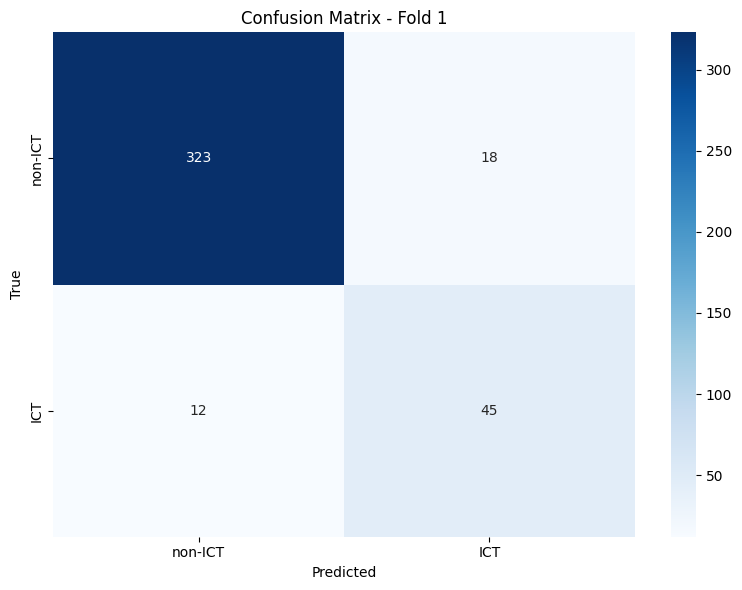

✅ Fold 1 completed!

🔥 FOLD 2/5
💾 Pre-fold GPU Memory: 0.02GB allocated, 0.04GB cached
📊 Original Train: 1589 samples, Val: 398 samples

🔄 Applying hybrid sampling to training data...
📊 Original class distribution:
    Majority class (0): 1361 samples
    Minority class (1): 228 samples
    Class imbalance ratio: 5.97:1
📊 After hybrid sampling:
    Majority class (0): 816 samples
    Minority class (1): 228 samples
    New class ratio: 3.58:1
    Total samples: 1044 (removed 545 majority samples, added 0 minority samples)
📊 After hybrid sampling - Train: 1044 samples

🔄 Calculating class weights...
📊 Calculated class weights:
    non-ICT (Class 0): 0.6397
    ICT (Class 1): 2.2895
🔄 Pre-tokenizing 1044 texts (max_length=256)...
    Tokenizing 500/1044...
    Tokenizing 1000/1044...
✅ Pre-tokenization complete: 1044 samples
🔄 Pre-tokenizing 398 texts (max_length=256)...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Pre-tokenization complete: 398 samples
🔄 Loading model with memory optimization...
💾 Post-model-load GPU Memory: 0.59GB allocated
✅ Using Focal Loss with gamma=2.0
✅ Gradient checkpointing enabled to save memory
🚀 Starting training for fold...

--- Epoch 1/3 ---
    🔍 Batch on device: cuda:0
    🔍 Model on device: Next param device: cuda:0
    📈 Batch 1/87 (1.1%) | Loss: 0.4287 | Acc: 58.33% | LR: 2.0e-05 | Time: 1.2s
    💾 GPU Memory: 2.31GB allocated, 2.94GB cached
    📈 Batch 11/87 (12.6%) | Loss: 0.1358 | Acc: 54.55% | LR: 2.0e-05 | Time: 12.4s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 21/87 (24.1%) | Loss: 0.2757 | Acc: 65.08% | LR: 2.0e-05 | Time: 24.3s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 31/87 (35.6%) | Loss: 0.1123 | Acc: 61.02% | LR: 2.0e-05 | Time: 36.4s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 41/87 (47.1%) | Loss: 0.2141 | Acc: 61.79% | LR: 2.0e-05 | Time: 47.9s
    💾 GPU Memory: 2.32GB allocated, 2.94GB c

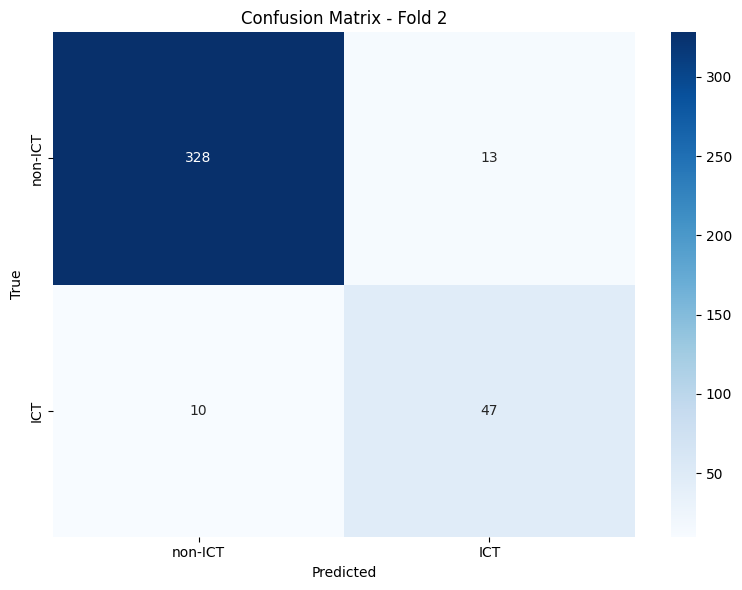

✅ Fold 2 completed!

🔥 FOLD 3/5
💾 Pre-fold GPU Memory: 0.02GB allocated, 0.04GB cached
📊 Original Train: 1590 samples, Val: 397 samples

🔄 Applying hybrid sampling to training data...
📊 Original class distribution:
    Majority class (0): 1362 samples
    Minority class (1): 228 samples
    Class imbalance ratio: 5.97:1
📊 After hybrid sampling:
    Majority class (0): 817 samples
    Minority class (1): 228 samples
    New class ratio: 3.58:1
    Total samples: 1045 (removed 545 majority samples, added 0 minority samples)
📊 After hybrid sampling - Train: 1045 samples

🔄 Calculating class weights...
📊 Calculated class weights:
    non-ICT (Class 0): 0.6395
    ICT (Class 1): 2.2917
🔄 Pre-tokenizing 1045 texts (max_length=256)...
    Tokenizing 500/1045...
    Tokenizing 1000/1045...
✅ Pre-tokenization complete: 1045 samples
🔄 Pre-tokenizing 397 texts (max_length=256)...
✅ Pre-tokenization complete: 397 samples
🔄 Loading model with memory optimization...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


💾 Post-model-load GPU Memory: 0.59GB allocated
✅ Using Focal Loss with gamma=2.0
✅ Gradient checkpointing enabled to save memory
🚀 Starting training for fold...

--- Epoch 1/3 ---
    🔍 Batch on device: cuda:0
    🔍 Model on device: Next param device: cuda:0
    📈 Batch 1/88 (1.1%) | Loss: 0.3812 | Acc: 16.67% | LR: 2.0e-05 | Time: 1.1s
    💾 GPU Memory: 2.31GB allocated, 2.94GB cached
    📈 Batch 11/88 (12.5%) | Loss: 0.0352 | Acc: 52.27% | LR: 2.0e-05 | Time: 12.2s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 21/88 (23.9%) | Loss: 0.2279 | Acc: 61.51% | LR: 2.0e-05 | Time: 23.9s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 31/88 (35.2%) | Loss: 0.3682 | Acc: 59.14% | LR: 2.0e-05 | Time: 36.0s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 41/88 (46.6%) | Loss: 0.0861 | Acc: 57.72% | LR: 2.0e-05 | Time: 47.7s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 51/88 (58.0%) | Loss: 0.1013 | Acc: 64.05% | LR: 2.0e-05 | Time: 59

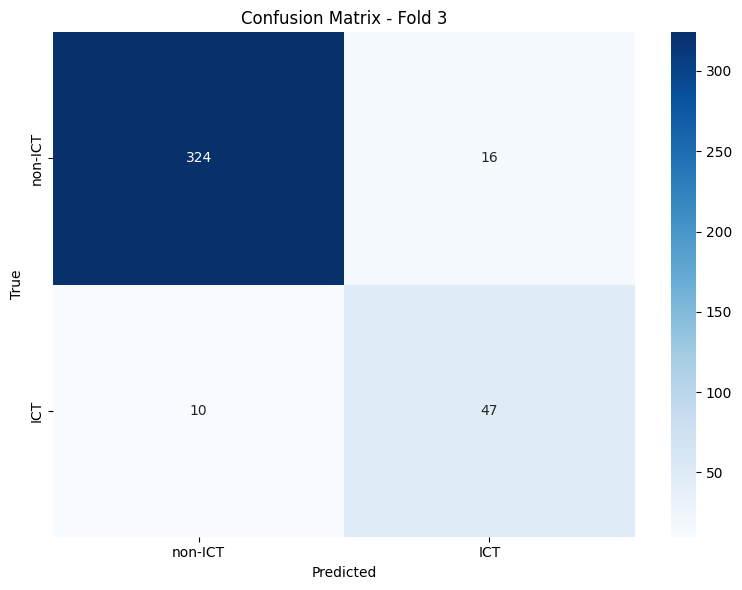

✅ Fold 3 completed!

🔥 FOLD 4/5
💾 Pre-fold GPU Memory: 0.02GB allocated, 0.04GB cached
📊 Original Train: 1590 samples, Val: 397 samples

🔄 Applying hybrid sampling to training data...
📊 Original class distribution:
    Majority class (0): 1362 samples
    Minority class (1): 228 samples
    Class imbalance ratio: 5.97:1
📊 After hybrid sampling:
    Majority class (0): 817 samples
    Minority class (1): 228 samples
    New class ratio: 3.58:1
    Total samples: 1045 (removed 545 majority samples, added 0 minority samples)
📊 After hybrid sampling - Train: 1045 samples

🔄 Calculating class weights...
📊 Calculated class weights:
    non-ICT (Class 0): 0.6395
    ICT (Class 1): 2.2917
🔄 Pre-tokenizing 1045 texts (max_length=256)...
    Tokenizing 500/1045...
    Tokenizing 1000/1045...
✅ Pre-tokenization complete: 1045 samples
🔄 Pre-tokenizing 397 texts (max_length=256)...
✅ Pre-tokenization complete: 397 samples
🔄 Loading model with memory optimization...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


💾 Post-model-load GPU Memory: 0.59GB allocated
✅ Using Focal Loss with gamma=2.0
✅ Gradient checkpointing enabled to save memory
🚀 Starting training for fold...

--- Epoch 1/3 ---
    🔍 Batch on device: cuda:0
    🔍 Model on device: Next param device: cuda:0
    📈 Batch 1/88 (1.1%) | Loss: 0.2312 | Acc: 33.33% | LR: 2.0e-05 | Time: 1.2s
    💾 GPU Memory: 2.31GB allocated, 2.94GB cached
    📈 Batch 11/88 (12.5%) | Loss: 0.1143 | Acc: 61.36% | LR: 2.0e-05 | Time: 12.4s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 21/88 (23.9%) | Loss: 0.0244 | Acc: 65.08% | LR: 2.0e-05 | Time: 24.3s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 31/88 (35.2%) | Loss: 0.1127 | Acc: 68.01% | LR: 2.0e-05 | Time: 36.4s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 41/88 (46.6%) | Loss: 0.1835 | Acc: 69.72% | LR: 2.0e-05 | Time: 47.9s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 51/88 (58.0%) | Loss: 0.0524 | Acc: 71.41% | LR: 2.0e-05 | Time: 59

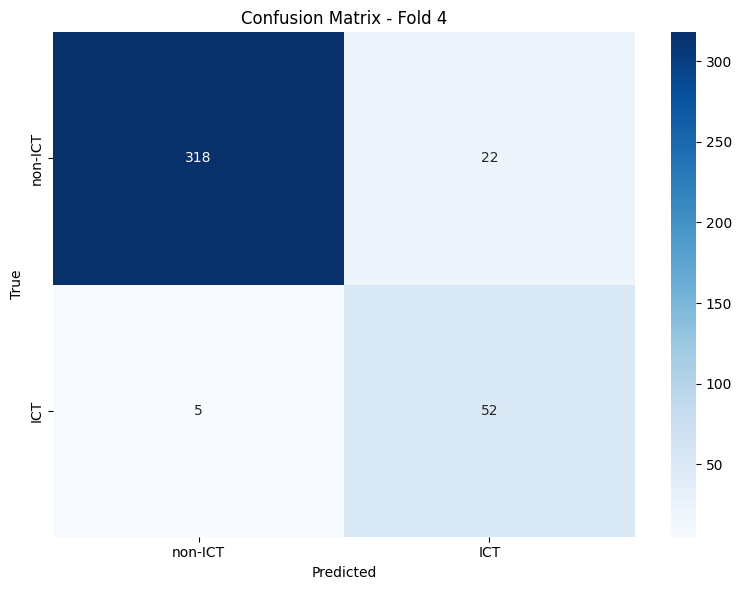

✅ Fold 4 completed!

🔥 FOLD 5/5
💾 Pre-fold GPU Memory: 0.02GB allocated, 0.04GB cached
📊 Original Train: 1590 samples, Val: 397 samples

🔄 Applying hybrid sampling to training data...
📊 Original class distribution:
    Majority class (0): 1362 samples
    Minority class (1): 228 samples
    Class imbalance ratio: 5.97:1
📊 After hybrid sampling:
    Majority class (0): 817 samples
    Minority class (1): 228 samples
    New class ratio: 3.58:1
    Total samples: 1045 (removed 545 majority samples, added 0 minority samples)
📊 After hybrid sampling - Train: 1045 samples

🔄 Calculating class weights...
📊 Calculated class weights:
    non-ICT (Class 0): 0.6395
    ICT (Class 1): 2.2917
🔄 Pre-tokenizing 1045 texts (max_length=256)...
    Tokenizing 500/1045...
    Tokenizing 1000/1045...
✅ Pre-tokenization complete: 1045 samples
🔄 Pre-tokenizing 397 texts (max_length=256)...
✅ Pre-tokenization complete: 397 samples
🔄 Loading model with memory optimization...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


💾 Post-model-load GPU Memory: 0.59GB allocated
✅ Using Focal Loss with gamma=2.0
✅ Gradient checkpointing enabled to save memory
🚀 Starting training for fold...

--- Epoch 1/3 ---
    🔍 Batch on device: cuda:0
    🔍 Model on device: Next param device: cuda:0
    📈 Batch 1/88 (1.1%) | Loss: 0.0181 | Acc: 100.00% | LR: 2.0e-05 | Time: 1.1s
    💾 GPU Memory: 2.31GB allocated, 2.94GB cached
    📈 Batch 11/88 (12.5%) | Loss: 0.1533 | Acc: 62.88% | LR: 2.0e-05 | Time: 12.4s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 21/88 (23.9%) | Loss: 0.1488 | Acc: 64.68% | LR: 2.0e-05 | Time: 24.2s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 31/88 (35.2%) | Loss: 0.1707 | Acc: 67.74% | LR: 2.0e-05 | Time: 36.3s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 41/88 (46.6%) | Loss: 0.2490 | Acc: 70.53% | LR: 2.0e-05 | Time: 47.8s
    💾 GPU Memory: 2.32GB allocated, 2.94GB cached
    📈 Batch 51/88 (58.0%) | Loss: 0.1312 | Acc: 70.42% | LR: 2.0e-05 | Time: 5

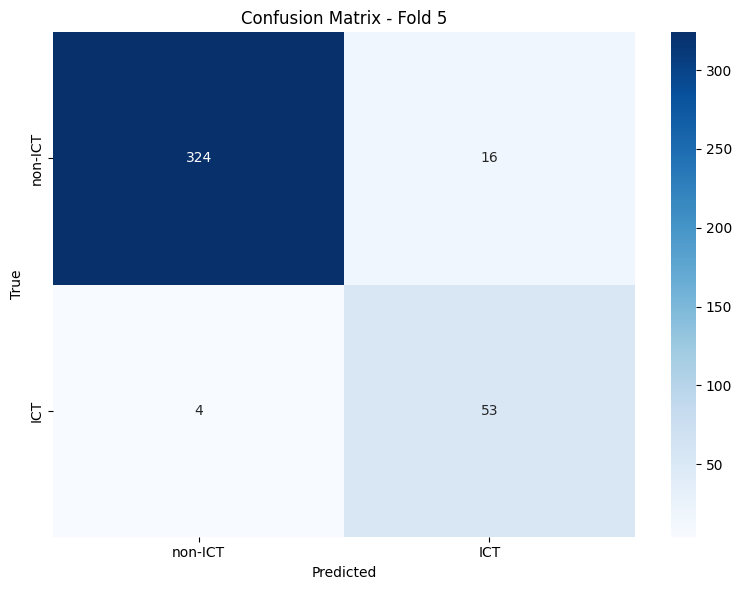

✅ Fold 5 completed!

🎯 FINAL CROSS-VALIDATION RESULTS
📊 Cross-Validation Average Metrics (based on best model per fold):
    Accuracy: 0.9366 ± 0.0086
    Precision: 0.7429 ± 0.0307
    Recall: 0.8561 ± 0.0548
    F1: 0.7944 ± 0.0296

🏆 Best Performing Fold (by F1 score): Fold 5 with F1: 0.8413

📊 Average Confusion Matrix across all folds:

✅ GPU-Optimized Training with Class Balancing Complete!
🏆 Best performing fold during cross-validation: 5
📁 Cross-validation fold results saved to /kaggle/working/gpu_fold_results_with_balancing.pkl

🧪 EVALUATING ON TEST SET
🔄 Loading best model from fold 5...

📊 Test Set Class Distribution:
    non-ICT (Class 0): 426 (85.7%)
    ICT (Class 1): 71 (14.3%)
📊 Creating test dataset with 497 samples...
🔄 Pre-tokenizing 497 texts (max_length=256)...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Pre-tokenization complete: 497 samples
✅ Successfully loaded best model from /kaggle/working/best_model_fold_5.pth
🔍 Using optimal threshold from best fold: 0.200

🔄 Calculating test class weights for evaluation...
📊 Calculated class weights:
    non-ICT (Class 0): 0.5833
    ICT (Class 1): 3.5000
✅ Using Focal Loss with gamma=2.0

🧪 Evaluating model on test set with default threshold (0.5)...

📊 Test Set Results with Default Threshold (0.5):
    Accuracy: 95.57%
    ICT Class (Minority):
      Precision: 0.9016
      Recall: 0.7746
      F1 Score: 0.8333

🧪 Applying optimal threshold (0.200) from cross-validation...

📊 Test Set Results with Optimal Threshold (0.200):
    Accuracy: 92.56%
    ICT Class (Minority):
      Precision: 0.6889
      Recall: 0.8732
      F1 Score: 0.7702

📋 Test Set Classification Report (with optimal threshold):
              precision    recall  f1-score   support

     non-ICT       0.98      0.93      0.96       426
         ICT       0.69      0.87    

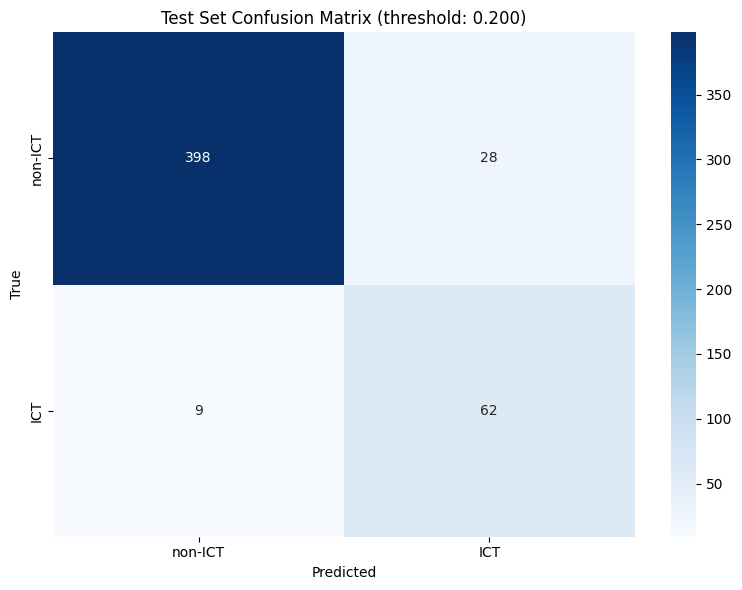


📈 Threshold Comparison - Confusion Matrix Improvement:
    Default Threshold (0.5):
      True Positives: 55, False Positives: 6
      True Negatives: 420, False Negatives: 16
    Optimal Threshold (0.200):
      True Positives: 62, False Positives: 28
      True Negatives: 398, False Negatives: 9
    Change with Optimal Threshold:
      True Positives: +12.7%
      False Positives: +366.7%

🔍 Finding optimal threshold directly on test set (for reference only)...
    Test set optimal threshold: 0.450 (F1: 0.8382)
    Cross-validation optimal threshold: 0.200 (F1: 0.7702)
📁 Test results saved to /kaggle/working/test_results_with_thresholds.pkl

✅ Evaluation Complete!
🏁 PIPELINE FINISHED SUCCESSFULLY


In [ ]:
# Alternative GPU-Optimized Approach with Native PyTorch
import os
import subprocess
import sys
import time
from datetime import datetime, timedelta
from collections import Counter
import random

# CRITICAL: Clear all GPU memory from previous runs FIRST
import torch
if torch.cuda.is_available():
    print("🧹 Clearing ALL GPU memory from previous runs...")
    torch.cuda.empty_cache()
    # Force garbage collection
    import gc
    gc.collect()
    # Clear memory more aggressively
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)
        torch.cuda.empty_cache()
    print("✅ GPU memory cleared!")

# Force GPU usage without complex multiprocessing
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Try a simpler import approach to avoid dependency issues
import pandas as pd
import numpy as np
import pickle
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import sklearn modules individually to avoid potential import errors
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix

# Import transformers after other imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# GPU setup and verification
def setup_gpu():
    if not torch.cuda.is_available():
        print("❌ No GPU available!")
        return torch.device('cpu'), False

    try:
        device = torch.device('cuda:0')
        torch.cuda.set_device(device)
    except RuntimeError as e:
        print(f"❌ Error setting CUDA device: {e}. Falling back to CPU.")
        return torch.device('cpu'), False

    print("🧪 Comprehensive GPU test...")
    try:
        # Test 1: Basic operations
        x = torch.randn(1000, 1000, device=device)
        y = torch.mm(x, x)
        print("✅ Basic GPU operations: OK")

        # Test 2: Gradient computation
        x.requires_grad_(True)
        z = (y * x).sum()
        z.backward()
        print("✅ GPU gradient computation: OK")

        # Test 3: Memory allocation
        large_tensor = torch.randn(5000, 5000, device=device)
        del large_tensor, x, y, z
        torch.cuda.empty_cache()
        print("✅ GPU memory management: OK")

        # Print GPU info
        gpu_name = torch.cuda.get_device_name(0)
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"🎮 GPU: {gpu_name}")
        print(f"💾 Total Memory: {total_memory:.1f} GB")

        return device, True
    except Exception as e:
        print(f"❌ GPU test failed: {e}")
        return torch.device('cpu'), False

# Set random seeds
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
device, gpu_available = setup_gpu()

# Combined under-sampling of majority class and over-sampling of minority class
def hybrid_sampling(texts, labels, target_ratio=0.25, random_state=42):
    """
    Hybrid approach: Undersample majority class + oversample minority class

    Args:
        texts: List of text samples
        labels: List of corresponding labels
        target_ratio: Target ratio of minority to majority class
        random_state: Random seed for reproducibility

    Returns:
        Tuple of (resampled_texts, resampled_labels)
    """
    random.seed(random_state)
    np.random.seed(random_state)

    # Convert to numpy arrays for easier manipulation
    texts_array = np.array(texts)
    labels_array = np.array(labels)

    # Count class distribution
    class_counts = Counter(labels)
    majority_class = max(class_counts, key=class_counts.get)
    minority_class = min(class_counts, key=class_counts.get)

    majority_count = class_counts[majority_class]
    minority_count = class_counts[minority_class]

    print(f"📊 Original class distribution:")
    print(f"    Majority class ({majority_class}): {majority_count} samples")
    print(f"    Minority class ({minority_class}): {minority_count} samples")
    print(f"    Class imbalance ratio: {majority_count/minority_count:.2f}:1")

    # Step 1: Undersample majority class by removing some samples
    # We'll keep majority_count * undersampling_ratio samples
    undersampling_ratio = 0.6  # Keep 60% of majority samples
    new_majority_count = int(majority_count * undersampling_ratio)

    # Get indices of majority class
    majority_indices = np.where(labels_array == majority_class)[0]
    # Randomly select indices to keep
    majority_indices_to_keep = np.random.choice(majority_indices, size=new_majority_count, replace=False)

    # Step 2: Oversample minority class
    # Calculate how many minority samples we need
    target_minority_count = int(new_majority_count * target_ratio)
    samples_to_add = max(0, target_minority_count - minority_count)

    # Get indices of minority class
    minority_indices = np.where(labels_array == minority_class)[0]

    # Randomly sample indices to duplicate (with replacement)
    additional_indices = np.random.choice(minority_indices, size=samples_to_add, replace=True)

    # Create resampled dataset
    # Combine kept majority samples and all original minority samples
    indices_to_keep = np.concatenate([majority_indices_to_keep, minority_indices])
    resampled_texts = texts_array[indices_to_keep].tolist()
    resampled_labels = labels_array[indices_to_keep].tolist()

    # Add oversampled minority samples
    resampled_texts.extend(texts_array[additional_indices].tolist())
    resampled_labels.extend(labels_array[additional_indices].tolist())

    # Shuffle the resampled data
    combined = list(zip(resampled_texts, resampled_labels))
    random.shuffle(combined)
    resampled_texts, resampled_labels = zip(*combined)

    # Report new distribution
    new_class_counts = Counter(resampled_labels)
    print(f"📊 After hybrid sampling:")
    print(f"    Majority class ({majority_class}): {new_class_counts[majority_class]} samples")
    print(f"    Minority class ({minority_class}): {new_class_counts[minority_class]} samples")
    print(f"    New class ratio: {new_class_counts[majority_class]/new_class_counts[minority_class]:.2f}:1")
    print(f"    Total samples: {len(resampled_texts)} (removed {majority_count - new_majority_count} majority samples, added {samples_to_add} minority samples)")

    return list(resampled_texts), list(resampled_labels)

# Calculate class weights for loss function
def calculate_class_weights(labels, device):
    """
    Calculate class weights inversely proportional to class frequencies.

    Args:
        labels: List of labels
        device: PyTorch device

    Returns:
        torch.Tensor: Class weights tensor
    """
    class_counts = Counter(labels)
    total_samples = len(labels)
    num_classes = len(class_counts)

    # Calculate weights: weight = total_samples / (num_classes * class_count)
    class_weights = {}
    for class_label in sorted(class_counts.keys()):
        weight = total_samples / (num_classes * class_counts[class_label])
        class_weights[class_label] = weight

    # Convert to tensor
    weights_tensor = torch.tensor([class_weights[i] for i in sorted(class_weights.keys())],
                                 dtype=torch.float32, device=device)

    print(f"📊 Calculated class weights:")
    for class_label, weight in class_weights.items():
        class_name = 'ICT' if class_label == 1 else 'non-ICT'
        print(f"    {class_name} (Class {class_label}): {weight:.4f}")

    return weights_tensor

# Optimized Dataset Class with Memory Management
class OptimizedResumeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        print(f"🔄 Pre-tokenizing {len(texts)} texts (max_length={max_length})...")
        self.tokenized_data = []

        for i, text in enumerate(texts):
            if i % 500 == 0 and i > 0:
                print(f"    Tokenizing {i}/{len(texts)}...")

            encoding = self.tokenizer(
                str(text),
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )

            self.tokenized_data.append({
                'input_ids': encoding['input_ids'].squeeze(0),
                'attention_mask': encoding['attention_mask'].squeeze(0),
                'labels': torch.tensor(labels[i], dtype=torch.long)
            })

        print(f"✅ Pre-tokenization complete: {len(self.tokenized_data)} samples")

    def __len__(self):
        return len(self.tokenized_data)

    def __getitem__(self, idx):
        return self.tokenized_data[idx]

# Custom Training Loop with Focal Loss and Threshold Adjustment
import torch.nn as nn
import torch.nn.functional as F

# Focal Loss Implementation with moderate gamma (2.0)
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Focal Loss for addressing class imbalance.

        Args:
            alpha: Weighting factor for rare class (can be scalar or tensor)
            gamma: Focusing parameter (higher gamma = more focus on hard examples)
            reduction: Specifies the reduction to apply to the output
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute cross entropy
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        # Compute p_t
        pt = torch.exp(-ce_loss)

        # Compute alpha_t (if alpha is provided)
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_t = self.alpha
            else:
                alpha_t = self.alpha[targets]
        else:
            alpha_t = 1.0

        # Compute focal loss
        focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names=['non-ICT', 'ICT'], title='Confusion Matrix'):
    """
    Plot confusion matrix with seaborn heatmap.

    Args:
        cm: Confusion matrix
        class_names: List of class names
        title: Title for the plot
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()

    # Save plot to file
    save_dir = '/kaggle/working'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    # Create a unique filename including timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{save_dir}/{title.replace(' ', '_')}_{timestamp}.png"
    plt.savefig(filename)

    print(f"📊 Confusion matrix saved to {filename}")
    plt.show()

class GPUTrainer:
    def __init__(self, model, device, batch_size=16, gradient_clip_val=1.0, class_weights=None, use_focal_loss=True, high_recall_mode=True):
        self.model = model.to(device)
        self.device = device
        self.batch_size = batch_size
        self.gradient_clip_val = gradient_clip_val
        self.use_focal_loss = use_focal_loss
        self.high_recall_mode = high_recall_mode  # Prioritize recall for minority class

        # Use Focal Loss or weighted CrossEntropyLoss
        if use_focal_loss:
            # Convert class weights to alpha for focal loss
            if class_weights is not None:
                alpha = class_weights.clone()
            else:
                alpha = None
            self.criterion = FocalLoss(alpha=alpha, gamma=2.0)  # Reduced gamma from 3.0 to 2.0
            print(f"✅ Using Focal Loss with gamma=2.0")
        else:
            # Use weighted CrossEntropyLoss if class weights are provided
            if class_weights is not None:
                self.criterion = nn.CrossEntropyLoss(weight=class_weights)
                print(f"✅ Using weighted CrossEntropyLoss with class weights")
            else:
                self.criterion = nn.CrossEntropyLoss()
                print(f"✅ Using standard CrossEntropyLoss")

    def train_epoch(self, train_loader, optimizer, epoch):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        start_time = time.time()

        for batch_idx, batch in enumerate(train_loader):
            # Explicit GPU transfer
            input_ids = batch['input_ids'].to(self.device, non_blocking=True if gpu_available else False)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True if gpu_available else False)
            labels = batch['labels'].to(self.device, non_blocking=True if gpu_available else False)

            if batch_idx == 0 and epoch == 0:
                print(f"    🔍 Batch on device: {input_ids.device}")
                print(f"    🔍 Model on device: Next param device: {next(self.model.parameters()).device}")

            optimizer.zero_grad()

            # Forward pass
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = self.criterion(logits, labels)

            # NOTE: Removed manual L2 regularization as AdamW's weight_decay handles this properly

            # Backward pass
            loss.backward()

            # Gradient Clipping
            if self.gradient_clip_val is not None and self.gradient_clip_val > 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_clip_val)

            optimizer.step()

            # Statistics
            total_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Progress updates
            if batch_idx % 10 == 0 or batch_idx == len(train_loader) - 1:
                elapsed = time.time() - start_time
                progress = (batch_idx + 1) / len(train_loader) * 100
                current_lr = optimizer.param_groups[0]['lr']
                print(f"    📈 Batch {batch_idx+1}/{len(train_loader)} ({progress:.1f}%) | "
                      f"Loss: {loss.item():.4f} | "
                      f"Acc: {100.*correct/total:.2f}% | "
                      f"LR: {current_lr:.1e} | "
                      f"Time: {elapsed:.1f}s")

                if gpu_available:
                    memory_allocated = torch.cuda.memory_allocated(self.device) / 1024**3
                    memory_cached = torch.cuda.memory_reserved(self.device) / 1024**3
                    print(f"    💾 GPU Memory: {memory_allocated:.2f}GB allocated, {memory_cached:.2f}GB cached")

        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        return avg_loss, accuracy

    def find_optimal_threshold(self, val_loader):
        """Find optimal classification threshold that maximizes F1 score or prioritizes recall."""
        self.model.eval()
        all_probs = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(self.device, non_blocking=True if gpu_available else False)
                attention_mask = batch['attention_mask'].to(self.device, non_blocking=True if gpu_available else False)
                labels = batch['labels'].to(self.device, non_blocking=True if gpu_available else False)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = F.softmax(logits, dim=1)

                all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class
                all_labels.extend(labels.cpu().numpy())

        # Try different thresholds
        thresholds = np.arange(0.1, 0.9, 0.05)
        best_f1 = 0
        best_threshold = 0.5

        # For high recall mode
        high_recall_threshold = 0.5
        highest_recall = 0

        for threshold in thresholds:
            predictions = (np.array(all_probs) >= threshold).astype(int)
            f1 = f1_score(all_labels, predictions, average='binary', pos_label=1, zero_division=0)
            recall = recall_score(all_labels, predictions, average='binary', pos_label=1, zero_division=0)
            precision = precision_score(all_labels, predictions, average='binary', pos_label=1, zero_division=0)

            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

            # Find threshold that gives highest recall while maintaining at least 0.7 precision (increased from 0.3)
            if recall > highest_recall and precision >= 0.7:
                highest_recall = recall
                high_recall_threshold = threshold

        # Use high recall threshold in high recall mode, otherwise use best F1 threshold
        optimal_threshold = high_recall_threshold if self.high_recall_mode else best_threshold

        return optimal_threshold, best_f1

    def evaluate(self, val_loader, find_threshold=False, threshold=0.5):
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(self.device, non_blocking=True if gpu_available else False)
                attention_mask = batch['attention_mask'].to(self.device, non_blocking=True if gpu_available else False)
                labels = batch['labels'].to(self.device, non_blocking=True if gpu_available else False)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = self.criterion(logits, labels)

                total_loss += loss.item()

                probs = F.softmax(logits, dim=1)
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class
                all_labels.extend(labels.cpu().numpy())

                _, predicted = torch.max(logits.data, 1)
                all_predictions.extend(predicted.cpu().numpy())

        # Convert to numpy arrays
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)
        all_predictions = np.array(all_predictions)

        avg_loss = total_loss / len(val_loader)

        # Standard metrics with 0.5 threshold
        std_preds = (all_probs >= 0.5).astype(int)
        accuracy = accuracy_score(all_labels, std_preds) * 100
        precision = precision_score(all_labels, std_preds, average='binary', pos_label=1, zero_division=0)
        recall = recall_score(all_labels, std_preds, average='binary', pos_label=1, zero_division=0)
        f1 = f1_score(all_labels, std_preds, average='binary', pos_label=1, zero_division=0)

        # Calculate confusion matrix
        cm = confusion_matrix(all_labels, std_preds)

        # Find optimal threshold if requested
        optimal_threshold = 0.5
        optimal_preds = std_preds
        optimal_cm = cm
        optimal_metrics = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

        if find_threshold:
            # Find optimal threshold for different criteria
            f1_thresholds = np.arange(0.1, 0.9, 0.05)
            best_f1 = 0
            best_f1_threshold = 0.5

            high_recall_threshold = 0.5
            highest_recall = 0

            for thresh in f1_thresholds:
                thresh_preds = (all_probs >= thresh).astype(int)
                thresh_f1 = f1_score(all_labels, thresh_preds, average='binary', pos_label=1, zero_division=0)
                thresh_recall = recall_score(all_labels, thresh_preds, average='binary', pos_label=1, zero_division=0)

                if thresh_f1 > best_f1:
                    best_f1 = thresh_f1
                    best_f1_threshold = thresh

                # Find threshold that gives highest recall while maintaining at least 0.7 precision
                thresh_precision = precision_score(all_labels, thresh_preds, average='binary', pos_label=1, zero_division=0)
                if thresh_recall > highest_recall and thresh_precision >= 0.7:  # Increased from 0.3 to 0.7
                    highest_recall = thresh_recall
                    high_recall_threshold = thresh

            # Use high recall threshold in high recall mode, otherwise use best F1 threshold
            optimal_threshold = high_recall_threshold if self.high_recall_mode else best_f1_threshold

            # Calculate metrics with optimal threshold
            optimal_preds = (all_probs >= optimal_threshold).astype(int)
            optimal_accuracy = accuracy_score(all_labels, optimal_preds) * 100
            optimal_precision = precision_score(all_labels, optimal_preds, average='binary', pos_label=1, zero_division=0)
            optimal_recall = recall_score(all_labels, optimal_preds, average='binary', pos_label=1, zero_division=0)
            optimal_f1 = f1_score(all_labels, optimal_preds, average='binary', pos_label=1, zero_division=0)

            optimal_cm = confusion_matrix(all_labels, optimal_preds)
            optimal_metrics = {
                'accuracy': optimal_accuracy,
                'precision': optimal_precision,
                'recall': optimal_recall,
                'f1': optimal_f1
            }

        return avg_loss, optimal_metrics, optimal_preds, all_labels, optimal_threshold, optimal_cm, all_probs

# Main training function with hybrid sampling and high recall focus
def train_with_gpu_optimization(texts, labels, n_splits=5, use_hybrid_sampling=True, use_class_weights=True, target_ratio=0.25):
    print("\n🚀 Starting GPU-Optimized Training with Class Balancing & Precision Focus")
    print("="*80)

    model_name = "answerdotai/ModernBERT-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Determine optimal settings
    optimal_batch_size = 16
    num_workers = 0
    if gpu_available:
        total_memory_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        print(f"    Detected GPU Total Memory: {total_memory_gb:.1f}GB")
        if total_memory_gb < 10:
             optimal_batch_size = 8
        elif total_memory_gb < 16:
             optimal_batch_size = 12
    else:
        optimal_batch_size = 8

    print(f"🔧 Configuration:")
    print(f"    Model: {model_name}")
    print(f"    Device: {device}")
    print(f"    Batch size: {optimal_batch_size}")
    print(f"    DataLoaders num_workers: {num_workers}")
    print(f"    GPU Available: {gpu_available}")
    print(f"    Use Hybrid Sampling: {use_hybrid_sampling}")
    print(f"    Use Class Weights: {use_class_weights}")
    print(f"    Focal Loss Gamma: 2.0 (balanced)")
    print(f"    Dropout Rate: 0.3 (added to model)")
    print(f"    Weight Decay: 0.02 (L2 regularization via AdamW)")
    print(f"    Min Precision Threshold: 0.7 (for optimal recall)")
    if use_hybrid_sampling:
        print(f"    Target Ratio (minority:majority): {target_ratio}")

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.array(texts), np.array(labels))):
        print(f"\n{'='*60}")
        print(f"🔥 FOLD {fold+1}/{n_splits}")
        print(f"{'='*60}")

        if gpu_available:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
            memory_allocated = torch.cuda.memory_allocated(device) / 1024**3
            memory_cached = torch.cuda.memory_reserved(device) / 1024**3
            print(f"💾 Pre-fold GPU Memory: {memory_allocated:.2f}GB allocated, {memory_cached:.2f}GB cached")

        # Use np.array for indexing compatibility with scikit-learn splits
        train_texts_fold = np.array(texts)[train_idx].tolist()
        val_texts_fold = np.array(texts)[val_idx].tolist()
        train_labels_fold = np.array(labels)[train_idx].tolist()
        val_labels_fold = np.array(labels)[val_idx].tolist()

        print(f"📊 Original Train: {len(train_texts_fold)} samples, Val: {len(val_texts_fold)} samples")

        # Apply hybrid sampling to training data if enabled
        if use_hybrid_sampling:
            print("\n🔄 Applying hybrid sampling to training data...")
            train_texts_fold, train_labels_fold = hybrid_sampling(
                train_texts_fold, train_labels_fold, target_ratio=target_ratio, random_state=42+fold
            )
            print(f"📊 After hybrid sampling - Train: {len(train_texts_fold)} samples")

        # Calculate class weights if enabled
        class_weights = None
        if use_class_weights:
            print("\n🔄 Calculating class weights...")
            class_weights = calculate_class_weights(train_labels_fold, device)

        train_dataset = OptimizedResumeDataset(train_texts_fold, train_labels_fold, tokenizer)
        val_dataset = OptimizedResumeDataset(val_texts_fold, val_labels_fold, tokenizer)

        train_loader = DataLoader(
            train_dataset, batch_size=optimal_batch_size, shuffle=True,
            num_workers=num_workers, pin_memory=gpu_available, persistent_workers=False if num_workers == 0 else True
        )
        val_loader = DataLoader(
            val_dataset, batch_size=optimal_batch_size, shuffle=False,
            num_workers=num_workers, pin_memory=gpu_available, persistent_workers=False if num_workers == 0 else True
        )

        print("🔄 Loading model with memory optimization...")
        config = {"hidden_dropout_prob": 0.3, "attention_probs_dropout_prob": 0.3}  # Increase dropout
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=2,
            low_cpu_mem_usage=True,
            config=config
        ).to(device)

        if gpu_available:
            memory_allocated = torch.cuda.memory_allocated(device) / 1024**3
            print(f"💾 Post-model-load GPU Memory: {memory_allocated:.2f}GB allocated")

        # Pass class weights to trainer with focal loss option and high recall mode
        trainer = GPUTrainer(
            model, device, optimal_batch_size, gradient_clip_val=1.0,
            class_weights=class_weights, use_focal_loss=True, high_recall_mode=True
        )

        # Use AdamW with moderate weight decay (L2 regularization)
        optimizer = torch.optim.AdamW(
            model.parameters(), lr=2e-5, weight_decay=0.02, eps=1e-8  # Reduced from 0.05 to 0.02
        )

        # Enable gradient checkpointing to save memory
        if hasattr(model, 'gradient_checkpointing_enable') and gpu_available:
            try:
                model.gradient_checkpointing_enable()
                print("✅ Gradient checkpointing enabled to save memory")
            except Exception as e:
                print(f"⚠️ Could not enable gradient checkpointing: {e}")

        best_f1 = 0
        patience = 3
        patience_counter = 0
        num_epochs = 3  # Reduced from 4 to 3

        print("🚀 Starting training for fold...")
        for epoch in range(num_epochs):
            epoch_start_time = time.time()
            print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")

            train_loss, train_acc = trainer.train_epoch(train_loader, optimizer, epoch)
            val_loss, val_metrics, val_preds, val_true, optimal_threshold, val_cm, val_probs = trainer.evaluate(val_loader, find_threshold=True)

            epoch_duration = time.time() - epoch_start_time

            print(f"📊 Epoch {epoch+1} Results:")
            print(f"    Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
            print(f"    Val   - Loss: {val_loss:.4f}, Acc: {val_metrics['accuracy']:.2f}%")
            print(f"    Val ICT Class - Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}")
            print(f"    Val F1: {val_metrics['f1']:.4f}")
            print(f"    Optimal Threshold: {optimal_threshold:.3f}")
            print(f"    Time: {epoch_duration:.1f}s")

            # Use F1 as primary metric
            if val_metrics['f1'] > best_f1:
                best_f1 = val_metrics['f1']
                patience_counter = 0
                if not os.path.exists('/kaggle/working'):
                    os.makedirs('/kaggle/working', exist_ok=True)
                torch.save(model.state_dict(), f'/kaggle/working/best_model_fold_{fold+1}.pth')
                print(f"    ⭐ New best F1: {best_f1:.4f}. Model saved.")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"    🛑 Early stopping triggered after {epoch+1} epochs.")
                    break

        print(f"\n📋 Fold {fold+1} Final Results:")
        # Load best model for this fold for final report if it was saved
        if os.path.exists(f'/kaggle/working/best_model_fold_{fold+1}.pth'):
            model.load_state_dict(torch.load(f'/kaggle/working/best_model_fold_{fold+1}.pth'))
            print("    Loaded best model for this fold to report metrics.")
            # Re-evaluate with the best model state for this fold using optimal threshold
            val_loss, val_metrics, val_preds, val_true, optimal_threshold, val_cm, val_probs = trainer.evaluate(val_loader, find_threshold=True)

        print(f"    Best Val F1 for this fold: {best_f1:.4f}")
        print(f"    Final Val F1 (with optimal threshold {optimal_threshold:.3f}): {val_metrics['f1']:.4f}")
        print(f"    Final Val metrics for ICT class (Class 1):")
        print(f"      Precision: {val_metrics['precision']:.4f}")
        print(f"      Recall: {val_metrics['recall']:.4f}")
        print(f"      F1: {val_metrics['f1']:.4f}")

        print(f"    Classification Report (with optimal threshold):")
        # Ensure target_names match the number of unique labels
        unique_labels_count = len(set(labels))
        target_names_report = [f'Class {i}' for i in range(unique_labels_count)]
        if unique_labels_count == 2:
            target_names_report = ['non-ICT', 'ICT']
        print(classification_report(val_true, val_preds, target_names=target_names_report, zero_division=0))

        # Plot confusion matrix for this fold
        print("\n📊 Fold Confusion Matrix:")
        plot_confusion_matrix(val_cm, class_names=target_names_report, title=f'Confusion Matrix - Fold {fold+1}')

        fold_results.append({
            'fold': fold+1,
            'accuracy': val_metrics['accuracy']/100,
            'precision': val_metrics['precision'],
            'recall': val_metrics['recall'],
            'f1': val_metrics['f1'],
            'optimal_threshold': optimal_threshold,
            'confusion_matrix': val_cm
        })

        del model, trainer, train_dataset, val_dataset, train_loader, val_loader, optimizer
        if gpu_available:
            torch.cuda.empty_cache()

        print(f"✅ Fold {fold+1} completed!")

    print(f"\n{'='*80}")
    print("🎯 FINAL CROSS-VALIDATION RESULTS")
    print(f"{'='*80}")

    if not fold_results:
        print("⚠️ No fold results to aggregate. Training might have failed or was skipped.")
        return [], -1

    avg_metrics = {
        metric: np.mean([r[metric] for r in fold_results])
        for metric in ['accuracy', 'precision', 'recall', 'f1']
    }
    std_metrics = {
        metric: np.std([r[metric] for r in fold_results])
        for metric in ['accuracy', 'precision', 'recall', 'f1']
    }

    print(f"📊 Cross-Validation Average Metrics (based on best model per fold):")
    for metric_name in ['accuracy', 'precision', 'recall', 'f1']:
        print(f"    {metric_name.capitalize()}: {avg_metrics[metric_name]:.4f} ± {std_metrics[metric_name]:.4f}")

    # Find best fold by F1 score
    best_overall_fold_info = max(fold_results, key=lambda x: x['f1'])
    print(f"\n🏆 Best Performing Fold (by F1 score): Fold {best_overall_fold_info['fold']} with F1: {best_overall_fold_info['f1']:.4f}")

    # Calculate average confusion matrix across all folds
    if all('confusion_matrix' in r for r in fold_results):
        #avg_cm = sum(r['confusion_matrix'] for r in fold_results) / len(fold_results)
        print("\n📊 Average Confusion Matrix across all folds:")
        unique_labels_count = len(set(labels))
        target_names = ['non-ICT', 'ICT'] if unique_labels_count == 2 else [f'Class {i}' for i in range(unique_labels_count)]
        #plot_confusion_matrix(avg_cm, class_names=target_names, title='Average Confusion Matrix - All Folds')

    return fold_results, best_overall_fold_info['fold']

# Load and preprocess data
print("📥 Loading data...")
# --- Create dummy data if file not found for local execution ---
data_file_path = '/kaggle/working/cv_data_with_ict_clusters.csv'
if not os.path.exists(data_file_path):
    print(f"⚠️ File {data_file_path} not found. Creating dummy data for demonstration.")
    if not os.path.exists('/kaggle/working'):
        os.makedirs('/kaggle/working', exist_ok=True)

    # Create a more substantial dummy dataset with class imbalance
    num_samples = 2000
    # Create imbalanced dataset (20% ICT, 80% non-ICT)
    ict_samples = int(num_samples * 0.2)
    non_ict_samples = num_samples - ict_samples

    dummy_texts_ict = [f"ict technical support engineer resume example {i}" for i in range(ict_samples)]
    dummy_texts_non_ict = [f"sales manager marketing skills cv {i}" for i in range(non_ict_samples)]
    dummy_labels_ict = ['ICT'] * ict_samples
    dummy_labels_non_ict = ['non-ICT'] * non_ict_samples

    all_dummy_texts = dummy_texts_ict + dummy_texts_non_ict
    all_dummy_labels = dummy_labels_ict + dummy_labels_non_ict

    # Shuffle the dummy data
    temp_df = pd.DataFrame({'full_text': all_dummy_texts, 'job_cluster_ICT': all_dummy_labels})
    temp_df = temp_df.sample(frac=1, random_state=42).reset_index(drop=True)

    temp_df.to_csv(data_file_path, index=False)
    cv_data = temp_df
else:
    cv_data = pd.read_csv(data_file_path)

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}', ' ', text)
    text = re.sub(r'[^\w\s.,!?-]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("🔄 Preprocessing data...")
cv_data['cleaned_text'] = cv_data['full_text'].apply(clean_text)
cv_data['cleaned_text'] = cv_data['cleaned_text'].fillna("")

if 'job_cluster_ICT' not in cv_data.columns:
    print("Error: 'job_cluster_ICT' column not found in the data. Please check your CSV file.")
    sys.exit(1)

cv_data['job_cluster_binary'] = (cv_data['job_cluster_ICT'] == 'ICT').astype(int)

class_counts = cv_data['job_cluster_binary'].value_counts()
print("\n📊 Original class distribution:")
for cls_val, count in class_counts.items():
    label = 'ICT' if cls_val == 1 else 'non-ICT'
    print(f"    {label} (Class {cls_val}): {count} ({count/len(cv_data)*100:.1f}%)")

# Check for class imbalance
minority_ratio = min(class_counts.values) / max(class_counts.values)
print(f"📊 Class imbalance ratio: {minority_ratio:.3f} (1.0 = balanced)")

texts_list = cv_data['cleaned_text'].tolist()
labels_list = cv_data['job_cluster_binary'].tolist()

# Check if lists are empty before splitting
if not texts_list or not labels_list:
    print("Error: Text or label lists are empty after preprocessing. Cannot proceed with training.")
    sys.exit(1)
if len(texts_list) != len(labels_list):
    print(f"Error: Mismatch in lengths of texts ({len(texts_list)}) and labels ({len(labels_list)}).")
    sys.exit(1)

# Stratified split for train/test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts_list, labels_list, test_size=0.2, random_state=42, stratify=labels_list
)

print(f"\n📊 Dataset splits:")
print(f"    Training: {len(train_texts)} samples")
print(f"    Testing: {len(test_texts)} samples (held out for final evaluation)")

# Configuration for class balancing techniques
USE_HYBRID_SAMPLING = True  # Combine oversampling with undersampling
USE_CLASS_WEIGHTS = True    # Use class weights to further address imbalance
TARGET_RATIO = 0.25         # Target ratio of 1:4 (ICT:non-ICT)

print(f"\n🎯 Class Balancing Configuration:")
print(f"    Hybrid sampling enabled: {USE_HYBRID_SAMPLING}")
print(f"    Class weights enabled: {USE_CLASS_WEIGHTS}")
if USE_HYBRID_SAMPLING:
    print(f"    Target ratio (minority:majority): {TARGET_RATIO} (1:4 ratio)")
    print(f"    Strategy: Undersample majority to 60% + oversample minority to match target ratio + focus on precision (min 0.7)")

# Run GPU-optimized training with class balancing
final_fold_results, final_best_fold = train_with_gpu_optimization(
    train_texts, train_labels, n_splits=5,
    use_hybrid_sampling=USE_HYBRID_SAMPLING,
    use_class_weights=USE_CLASS_WEIGHTS,
    target_ratio=TARGET_RATIO
)

# Save results
results_path = '/kaggle/working/gpu_fold_results_with_balancing.pkl'
if not os.path.exists('/kaggle/working'):
    os.makedirs('/kaggle/working', exist_ok=True)
with open(results_path, 'wb') as f:
    pickle.dump(final_fold_results, f)

print("\n✅ GPU-Optimized Training with Class Balancing Complete!")
if final_fold_results:
    print(f"🏆 Best performing fold during cross-validation: {final_best_fold}")
    print(f"📁 Cross-validation fold results saved to {results_path}")
else:
    print("⚠️ Training completed, but no fold results were generated.")

# Improved Test Set Evaluation
print(f"\n{'='*80}")
print("🧪 EVALUATING ON TEST SET")
print(f"{'='*80}")

if final_fold_results and final_best_fold > 0:
    print(f"🔄 Loading best model from fold {final_best_fold}...")

    # Initialize tokenizer and model architecture
    model_name = "answerdotai/ModernBERT-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Display test set class distribution
    test_class_counts = Counter(test_labels)
    print("\n📊 Test Set Class Distribution:")
    for cls_val, count in test_class_counts.items():
        class_name = 'ICT' if cls_val == 1 else 'non-ICT'
        print(f"    {class_name} (Class {cls_val}): {count} ({count/len(test_labels)*100:.1f}%)")

    # Create test dataset
    print(f"📊 Creating test dataset with {len(test_texts)} samples...")
    test_dataset = OptimizedResumeDataset(test_texts, test_labels, tokenizer)

    # Determine optimal batch size (reusing logic from above)
    optimal_batch_size = 16
    num_workers = 0
    if gpu_available:
        total_memory_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        if total_memory_gb < 10:
             optimal_batch_size = 8
        elif total_memory_gb < 16:
             optimal_batch_size = 12
    else:
        optimal_batch_size = 8

    # Create test dataloader
    test_loader = DataLoader(
        test_dataset, batch_size=optimal_batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=gpu_available
    )

    # Load model architecture with same dropout
    config = {"hidden_dropout_prob": 0.3, "attention_probs_dropout_prob": 0.3}
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=2,
        low_cpu_mem_usage=True,
        config=config
    ).to(device)

    # Load best weights from cross-validation
    best_model_path = f'/kaggle/working/best_model_fold_{final_best_fold}.pth'
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path))
        print(f"✅ Successfully loaded best model from {best_model_path}")

        # Get the optimal threshold from best fold
        optimal_threshold = next((fold['optimal_threshold'] for fold in final_fold_results if fold['fold'] == final_best_fold), 0.5)
        print(f"🔍 Using optimal threshold from best fold: {optimal_threshold:.3f}")

        # Get class weights from test data if using class weights
        test_class_weights = None
        if USE_CLASS_WEIGHTS:
            print("\n🔄 Calculating test class weights for evaluation...")
            test_class_weights = calculate_class_weights(test_labels, device)

        # Initialize trainer with high recall mode and possibly class weights
        trainer = GPUTrainer(
            model, device, optimal_batch_size,
            class_weights=test_class_weights,
            use_focal_loss=True,
            high_recall_mode=True
        )

        # Evaluate on test set with both default threshold (0.5) and optimal threshold
        print("\n🧪 Evaluating model on test set with default threshold (0.5)...")
        test_loss, default_metrics, default_preds, test_true, _, default_cm, test_probs = trainer.evaluate(
            test_loader, find_threshold=False, threshold=0.5
        )

        print(f"\n📊 Test Set Results with Default Threshold (0.5):")
        print(f"    Accuracy: {default_metrics['accuracy']:.2f}%")
        print(f"    ICT Class (Minority):")
        print(f"      Precision: {default_metrics['precision']:.4f}")
        print(f"      Recall: {default_metrics['recall']:.4f}")
        print(f"      F1 Score: {default_metrics['f1']:.4f}")

        # Apply optimal threshold from CV
        print(f"\n🧪 Applying optimal threshold ({optimal_threshold:.3f}) from cross-validation...")
        optimal_preds = (np.array(test_probs) >= optimal_threshold).astype(int)
        optimal_accuracy = accuracy_score(test_true, optimal_preds) * 100
        optimal_precision = precision_score(test_true, optimal_preds, average='binary', pos_label=1, zero_division=0)
        optimal_recall = recall_score(test_true, optimal_preds, average='binary', pos_label=1, zero_division=0)
        optimal_f1 = f1_score(test_true, optimal_preds, average='binary', pos_label=1, zero_division=0)
        optimal_cm = confusion_matrix(test_true, optimal_preds)

        # Print test metrics with optimal threshold
        print(f"\n📊 Test Set Results with Optimal Threshold ({optimal_threshold:.3f}):")
        print(f"    Accuracy: {optimal_accuracy:.2f}%")
        print(f"    ICT Class (Minority):")
        print(f"      Precision: {optimal_precision:.4f}")
        print(f"      Recall: {optimal_recall:.4f}")
        print(f"      F1 Score: {optimal_f1:.4f}")

        # Print classification report
        print("\n📋 Test Set Classification Report (with optimal threshold):")
        target_names = ['non-ICT', 'ICT'] if len(set(test_labels)) == 2 else [f'Class {i}' for i in range(len(set(test_labels)))]
        print(classification_report(test_true, optimal_preds, target_names=target_names, zero_division=0))

        # Plot confusion matrix with optimal threshold
        print("\n📊 Test Set Confusion Matrix (with optimal threshold):")
        plot_confusion_matrix(optimal_cm, class_names=target_names,
                             title=f'Test Set Confusion Matrix (threshold: {optimal_threshold:.3f})')

        # Compute confusion matrix improvement
        print("\n📈 Threshold Comparison - Confusion Matrix Improvement:")
        default_tn, default_fp, default_fn, default_tp = default_cm.ravel()
        optimal_tn, optimal_fp, optimal_fn, optimal_tp = optimal_cm.ravel()

        print(f"    Default Threshold (0.5):")
        print(f"      True Positives: {default_tp}, False Positives: {default_fp}")
        print(f"      True Negatives: {default_tn}, False Negatives: {default_fn}")

        print(f"    Optimal Threshold ({optimal_threshold:.3f}):")
        print(f"      True Positives: {optimal_tp}, False Positives: {optimal_fp}")
        print(f"      True Negatives: {optimal_tn}, False Negatives: {optimal_fn}")

        # Calculate improvement percentages
        tp_change = ((optimal_tp - default_tp) / default_tp * 100) if default_tp > 0 else float('inf')
        fp_change = ((optimal_fp - default_fp) / default_fp * 100) if default_fp > 0 else float('inf')

        print(f"    Change with Optimal Threshold:")
        print(f"      True Positives: {'+' if tp_change >= 0 else ''}{tp_change:.1f}%")
        print(f"      False Positives: {'+' if fp_change >= 0 else ''}{fp_change:.1f}%")

        # Try finding an optimal threshold directly on the test set (for comparison only)
        print("\n🔍 Finding optimal threshold directly on test set (for reference only)...")
        thresholds = np.arange(0.1, 0.9, 0.05)
        best_f1 = 0
        best_f1_threshold = 0.5

        for thresh in thresholds:
            thresh_preds = (np.array(test_probs) >= thresh).astype(int)
            thresh_f1 = f1_score(test_true, thresh_preds, average='binary', pos_label=1, zero_division=0)

            if thresh_f1 > best_f1:
                best_f1 = thresh_f1
                best_f1_threshold = thresh

        print(f"    Test set optimal threshold: {best_f1_threshold:.3f} (F1: {best_f1:.4f})")
        print(f"    Cross-validation optimal threshold: {optimal_threshold:.3f} (F1: {optimal_f1:.4f})")

        # Save test results
        test_results = {
            'default_threshold': {
                'threshold': 0.5,
                'accuracy': default_metrics['accuracy']/100,
                'precision': default_metrics['precision'],
                'recall': default_metrics['recall'],
                'f1': default_metrics['f1'],
                'confusion_matrix': default_cm.tolist()
            },
            'optimal_threshold': {
                'threshold': optimal_threshold,
                'accuracy': optimal_accuracy/100,
                'precision': optimal_precision,
                'recall': optimal_recall,
                'f1': optimal_f1,
                'confusion_matrix': optimal_cm.tolist()
            },
            'test_optimal_threshold': {
                'threshold': best_f1_threshold,
                'f1': best_f1
            }
        }

        test_results_path = '/kaggle/working/test_results_with_thresholds.pkl'
        with open(test_results_path, 'wb') as f:
            pickle.dump(test_results, f)
        print(f"📁 Test results saved to {test_results_path}")

        # Clean up
        del model, trainer, test_dataset, test_loader
        if gpu_available:
            torch.cuda.empty_cache()
    else:
        print(f"❌ Could not find best model at {best_model_path}. Cannot evaluate on test set.")
else:
    print("❌ No fold results or invalid best fold. Cannot evaluate on test set.")

print("\n✅ Evaluation Complete!")
print(f"{'='*80}")
print("🏁 PIPELINE FINISHED SUCCESSFULLY")
print(f"{'='*80}")

In [ ]:
#raise SystemExit()

# PHASE 3, SPLIT-CELLS FOR DEBIASING-GAN PIPELINE